In [177]:
from chromatic_fitting import *
from chromatic import Rainbow, SimulatedRainbow
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from tqdm import tqdm
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter
plt.matplotlib.style.use('default')

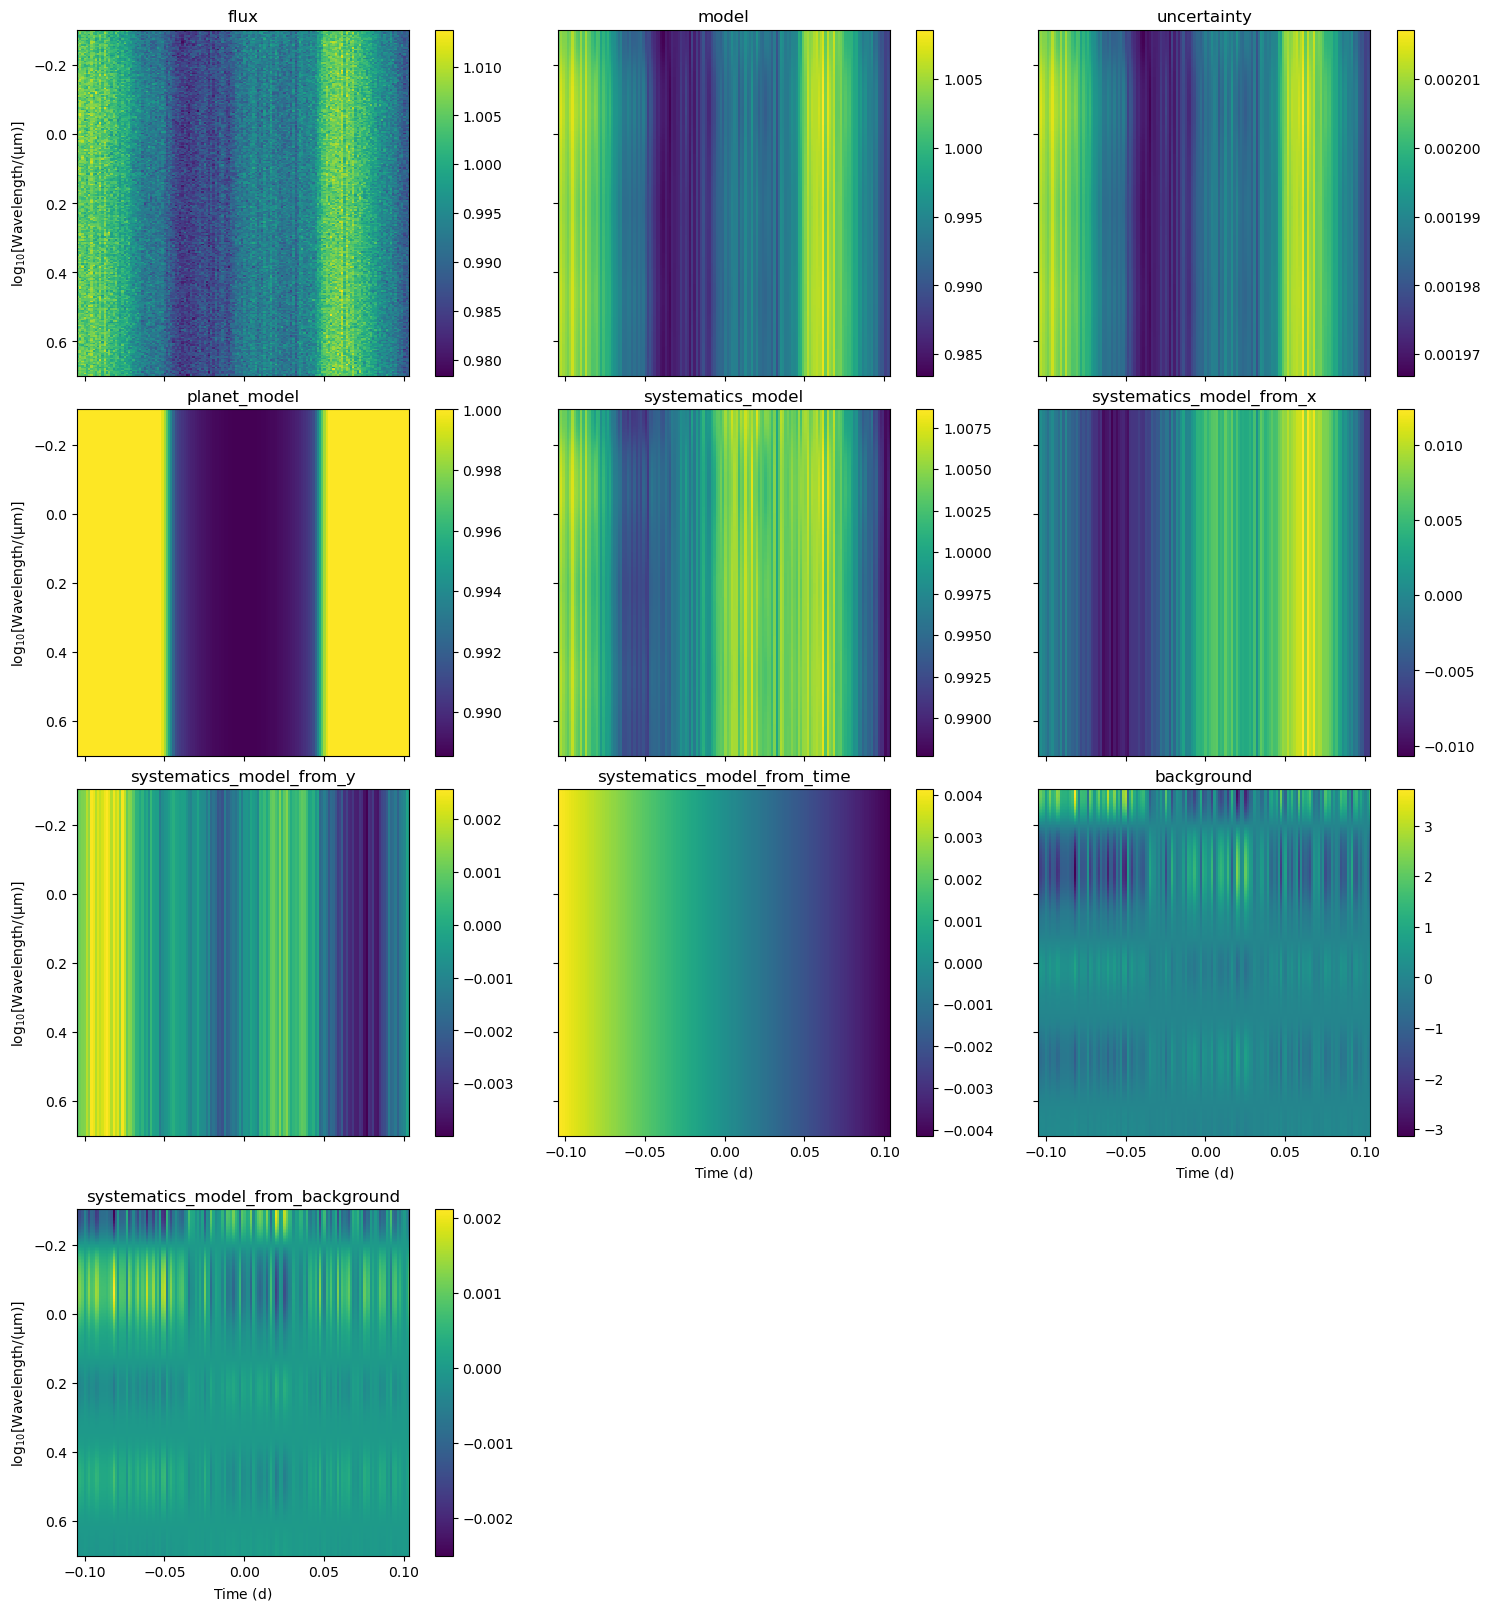

In [178]:
r_systematics = SimulatedRainbow().inject_transit().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500)
r_systematics.imshow_quantities();
r_systematics = r_systematics.bin(nwavelengths=int(r_systematics.nwave/5), dt=5 * u.minute)

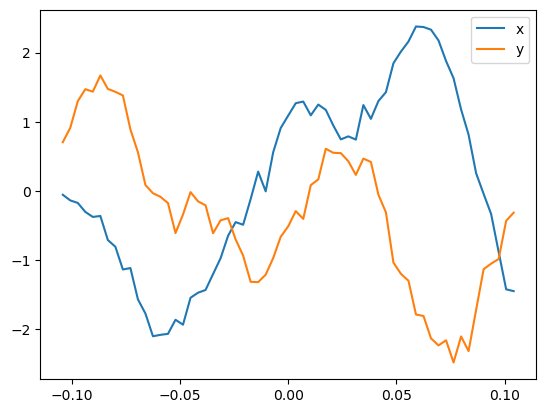

In [179]:
plt.plot(r_systematics.time,r_systematics.x,label='x')
plt.plot(r_systematics.time,r_systematics.y,label='y')
plt.legend()

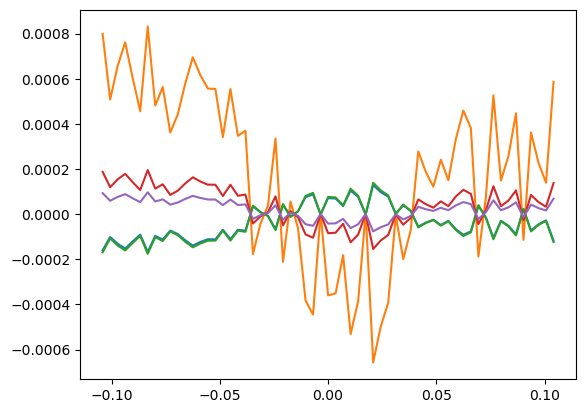

In [180]:
plt.plot(r_systematics.time,r_systematics.systematics_model_from_background[0,:],label='systematics_x')
plt.plot(r_systematics.time,r_systematics.systematics_model_from_background[1,:],label='systematics_x')
plt.plot(r_systematics.time,r_systematics.systematics_model_from_background[2,:],label='systematics_x')
plt.plot(r_systematics.time,r_systematics.systematics_model_from_background[3,:],label='systematics_x')
plt.plot(r_systematics.time,r_systematics.systematics_model_from_background[4,:],label='systematics_x')

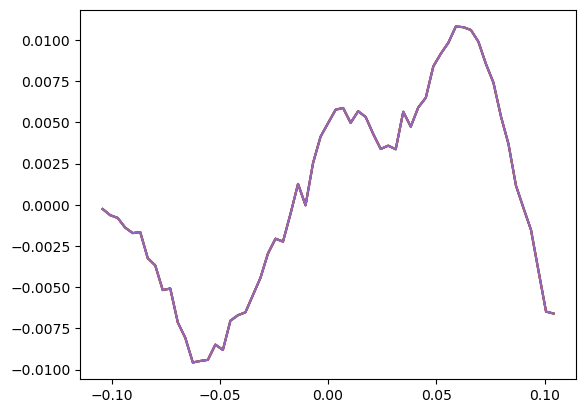

In [181]:
plt.plot(r_systematics.time,r_systematics.systematics_model_from_x[0,:],label='systematics_x')
plt.plot(r_systematics.time,r_systematics.systematics_model_from_x[1,:],label='systematics_x')
plt.plot(r_systematics.time,r_systematics.systematics_model_from_x[2,:],label='systematics_x')
plt.plot(r_systematics.time,r_systematics.systematics_model_from_x[3,:],label='systematics_x')
plt.plot(r_systematics.time,r_systematics.systematics_model_from_x[4,:],label='systematics_x')

<AxesSubplot:xlabel='Time ($\\mathrm{d}$)', ylabel='log$_{10}$[Wavelength/($\\mathrm{\\mu m}$)]'>

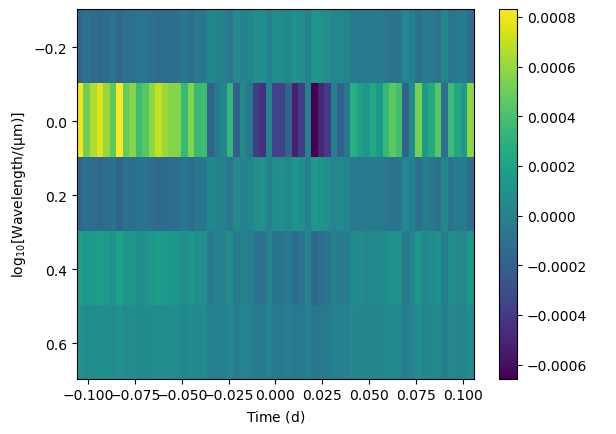

In [182]:
r_systematics.imshow(quantity='systematics_model_from_background')

<AxesSubplot:xlabel='Time ($\\mathrm{d}$)', ylabel='log$_{10}$[Wavelength/($\\mathrm{\\mu m}$)]'>

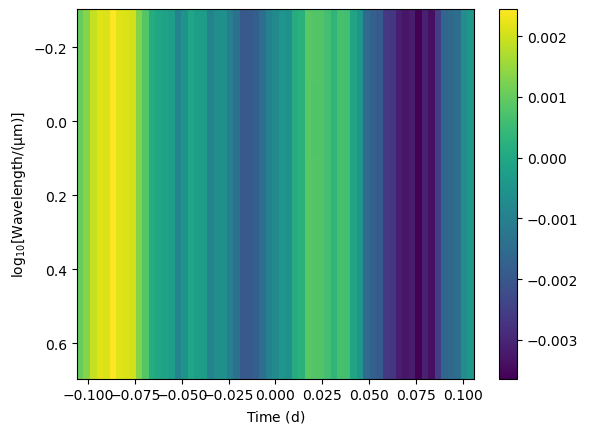

In [183]:
r_systematics.imshow(quantity='systematics_model_from_y')

In [154]:
# set up transit model:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
                )

# set up time polynomial model:
b = PolynomialModel(degree=1)
b.initialize_empty_model()
b.setup_parameters(
    p_1 = Fitted(Uniform,testval=0.0,upper=1.0,lower=-1.0),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, indep_var="x")
b_x.initialize_empty_model()
b_x.setup_parameters(
    p_1 = Fitted(Uniform,testval=0.0,upper=1.0,lower=-1.0),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, indep_var="y")
b_y.initialize_empty_model()
b_y.setup_parameters(
    p_1 = Fitted(Uniform,testval=0.0,upper=1.0,lower=-1.0),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, indep_var="background")
b_bkg.initialize_empty_model()
b_bkg.setup_parameters(
    p_1 = WavelikeFitted(Uniform,testval=0.0,upper=1.0,lower=-1.0),
)

In [155]:
## combine the models!
cm = CombinedModel()
cm.initialize_empty_model()
cm.attach_models({'transit':t,'time':b,'x':b_x,'y':b_y,'background':b_bkg})
cm.attach_data(r_systematics)
cm.setup_lightcurves()
cm.setup_likelihood()
print(cm.chromatic_models)
print(cm.pymc3_model)

100%|█████████████████████████████████████████| 5/5 [00:00<00:00, 108660.73it/s]


{'transit': <experimental chromatic transit model 🌈>, 'time': <experimental chromatic polynomial model 🌈>, 'x': <experimental chromatic polynomial model 🌈>, 'y': <experimental chromatic polynomial model 🌈>, 'background': <experimental chromatic polynomial model 🌈>}
             transit_epoch_interval__ ~ TransformedDistribution
    transit_impact_parameter_impact__ ~ TransformedDistribution
    transit_stellar_radius_interval__ ~ TransformedDistribution
      transit_stellar_mass_interval__ ~ TransformedDistribution
transit_limb_darkening_quadlimbdark__ ~ TransformedDistribution
              transit_radius_ratio_w0 ~ Normal
          transit_baseline_interval__ ~ TransformedDistribution
              transit_radius_ratio_w1 ~ Normal
              transit_radius_ratio_w2 ~ Normal
              transit_radius_ratio_w3 ~ Normal
              transit_radius_ratio_w4 ~ Normal
                  time_p_1_interval__ ~ TransformedDistribution
                     x_p_1_interval__ ~ Transformed

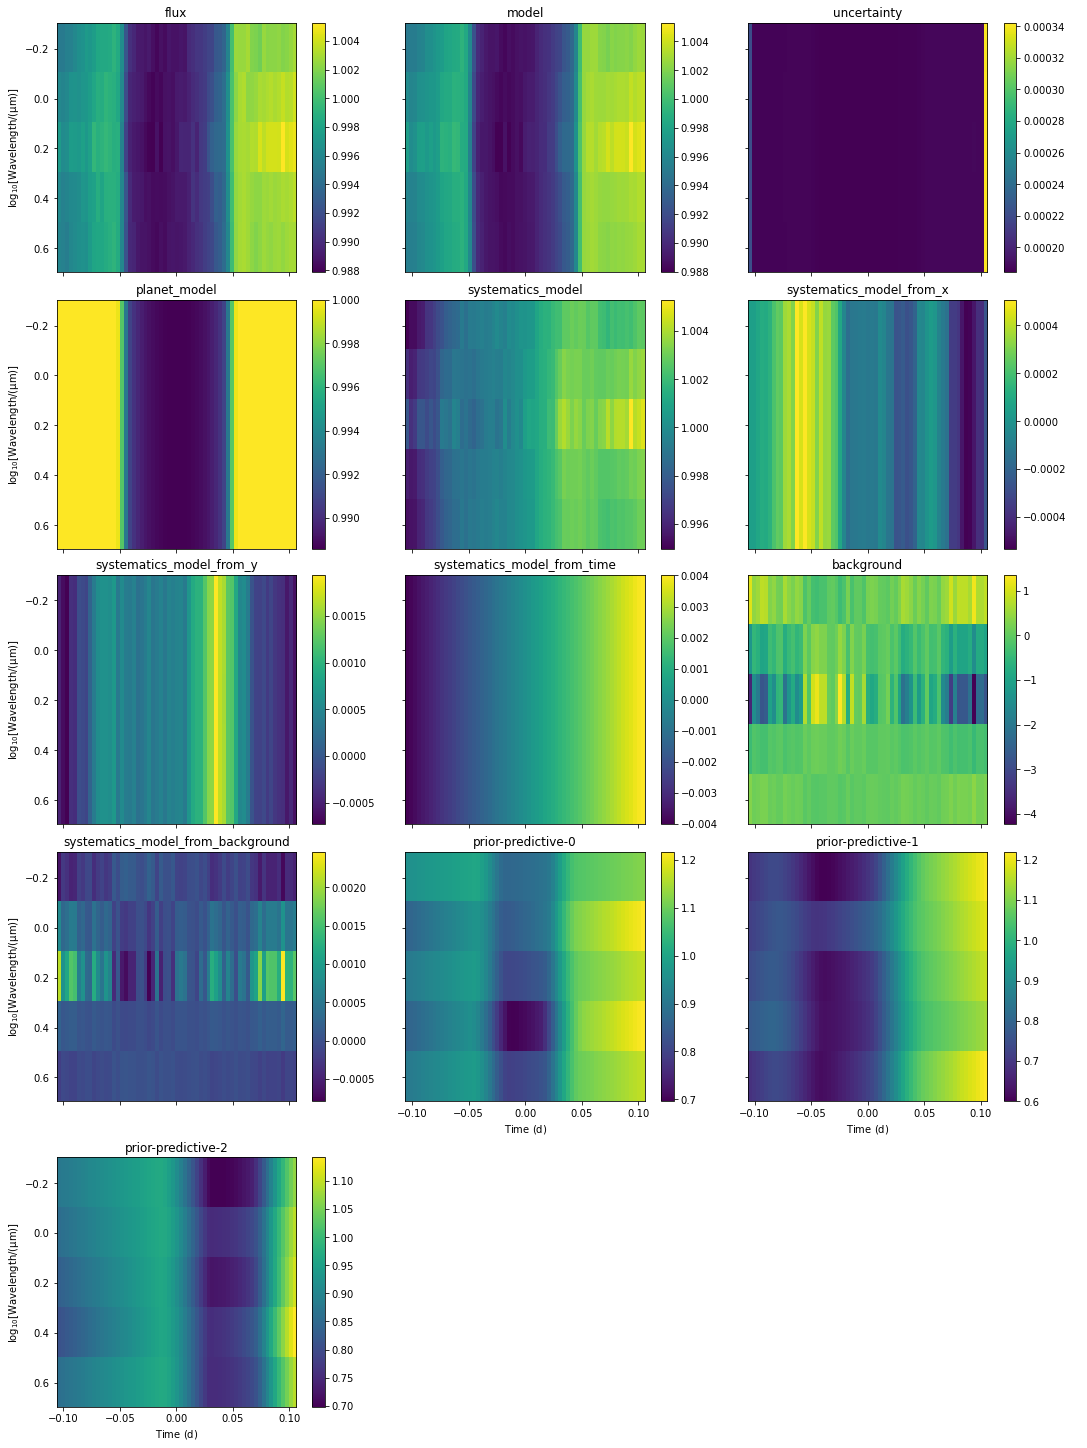

In [156]:
cm.plot_priors()

In [157]:
opt = cm.optimize()
cm.sample(start=opt, cores=12, chains=4) #tune=2000, draws=2000,
cm.summarize(round_to=7, fmt='wide')

optimizing logp for variables: [background_p_1_w4, background_p_1_w3, background_p_1_w2, background_p_1_w1, background_p_1_w0, y_p_1, x_p_1, time_p_1, transit_radius_ratio_w4, transit_radius_ratio_w3, transit_radius_ratio_w2, transit_radius_ratio_w1, transit_baseline, transit_radius_ratio_w0, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


message: Desired error not necessarily achieved due to precision loss.
logp: -64827666.082853824 -> -214546.93695599737



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [background_p_1_w4, background_p_1_w3, background_p_1_w2, background_p_1_w1, background_p_1_w0, y_p_1, x_p_1, time_p_1, transit_radius_ratio_w4, transit_radius_ratio_w3, transit_radius_ratio_w2, transit_radius_ratio_w1, transit_baseline, transit_radius_ratio_w0, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1719 seconds.
There were 293 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


                               mean        sd    hdi_3%   hdi_97%  \
transit_radius_ratio_w0    0.096927  0.000234  0.096516  0.097401   
transit_radius_ratio_w1    0.096934  0.000234  0.096515  0.097392   
transit_radius_ratio_w2    0.096684  0.000238  0.096243  0.097118   
transit_radius_ratio_w3    0.097003  0.000230  0.096571  0.097434   
transit_radius_ratio_w4    0.097283  0.000227  0.096851  0.097704   
transit_epoch             -0.000531  0.000042 -0.000612 -0.000454   
transit_impact_parameter   0.034942  0.031376  0.000034  0.093418   
transit_stellar_radius     1.174346  0.017272  1.148141  1.199998   
transit_stellar_mass       0.869418  0.038031  0.809934  0.929120   
transit_limb_darkening[0]  0.606912  0.024950  0.559443  0.652086   
transit_limb_darkening[1] -0.195511  0.047560 -0.285506 -0.108549   
transit_baseline           1.000189  0.000015  1.000162  1.000217   
time_p_1                   0.008196  0.008376  0.000000  0.024069   
x_p_1                      0.01253

Got error No model on context stack. trying to find log_likelihood in translation.

🌈 Warning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'transit_radius_ratio_w0'}>,
        <AxesSubplot:title={'center':'transit_radius_ratio_w0'}>],
       [<AxesSubplot:title={'center':'transit_radius_ratio_w1'}>,
        <AxesSubplot:title={'center':'transit_radius_ratio_w1'}>],
       [<AxesSubplot:title={'center':'transit_radius_ratio_w2'}>,
        <AxesSubplot:title={'center':'transit_radius_ratio_w2'}>],
       [<AxesSubplot:title={'center':'transit_radius_ratio_w3'}>,
        <AxesSubplot:title={'center':'transit_radius_ratio_w3'}>],
       [<AxesSubplot:title={'center':'transit_radius_ratio_w4'}>,
        <AxesSubplot:title={'center':'transit_radius_ratio_w4'}>],
       [<AxesSubplot:title={'center':'transit_epoch'}>,
        <AxesSubplot:title={'center':'transit_epoch'}>],
       [<AxesSubplot:title={'center':'transit_impact_parameter'}>,
        <AxesSubplot:title={'center':'transit_impact_parameter'}>],
       [<AxesSubplot:title={'center':'transit_stellar_radius'}>,
        <AxesSubplot:t

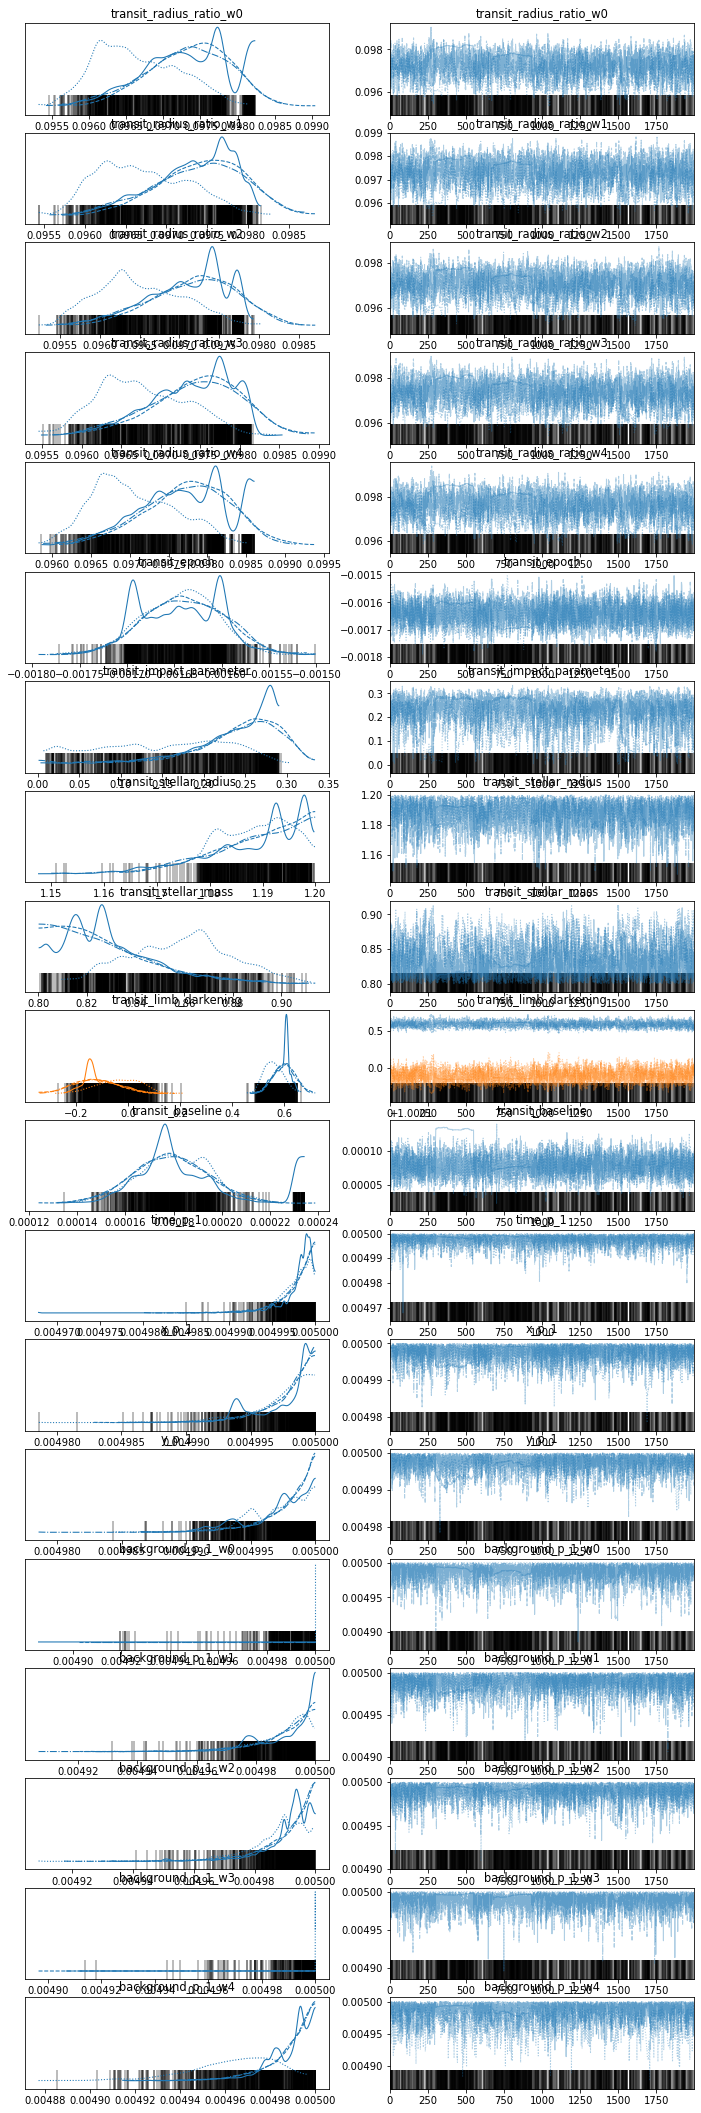

In [153]:
az.plot_trace(cm.trace);


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

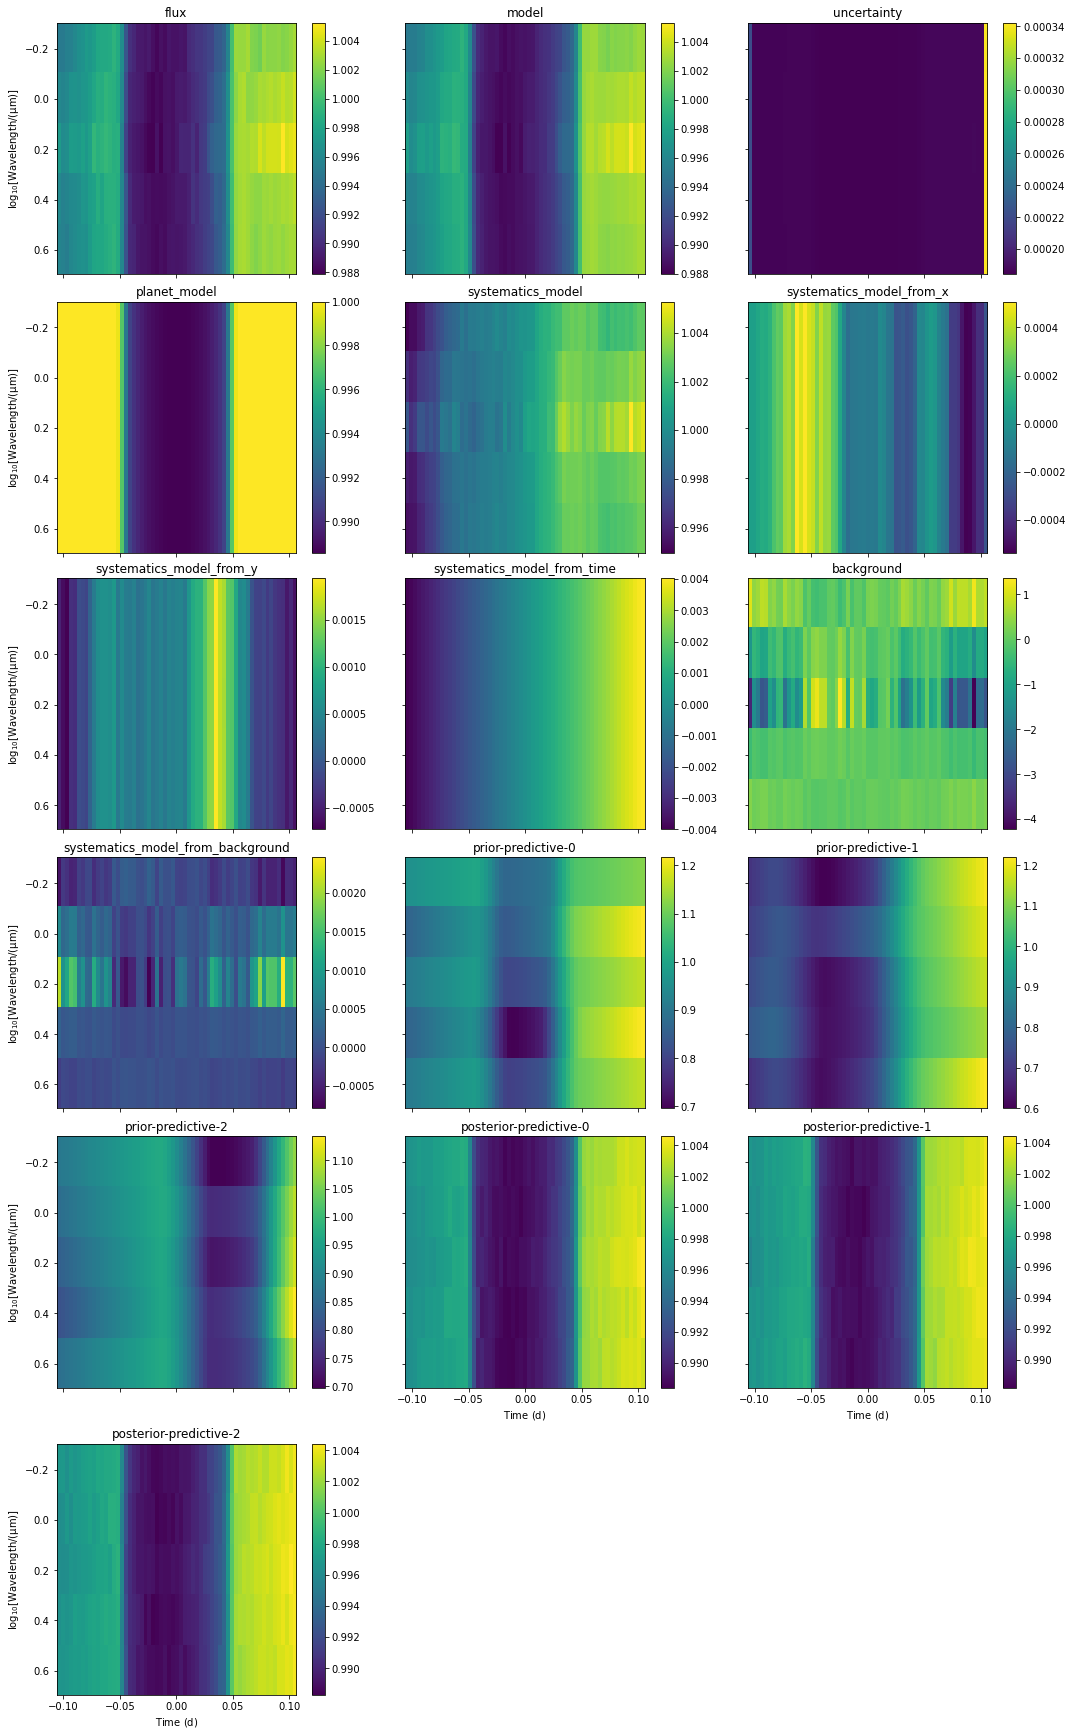

In [158]:
cm.plot_posteriors()

transit_radius_ratio_w0      0.096927
transit_radius_ratio_w1      0.096934
transit_radius_ratio_w2      0.096684
transit_radius_ratio_w3      0.097003
transit_radius_ratio_w4      0.097283
transit_epoch               -0.000531
transit_impact_parameter     0.034942
transit_stellar_radius       1.174346
transit_stellar_mass         0.869418
transit_limb_darkening[0]    0.606912
transit_limb_darkening[1]   -0.195511
transit_baseline             1.000189
time_p_1                     0.008196
x_p_1                        0.012536
y_p_1                        0.008284
background_p_1_w0            0.005241
background_p_1_w1            0.007715
background_p_1_w2            0.010086
background_p_1_w3            0.006933
background_p_1_w4            0.006390
Name: mean, dtype: float64


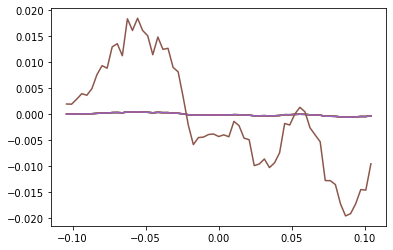

In [159]:
mean_params = cm.summary['mean']
print(mean_params)
plt.plot(r_systematics.time,r_systematics.systematics_model_from_x[0,:])
plt.plot(r_systematics.time,r_systematics.systematics_model_from_x[1,:])
plt.plot(r_systematics.time,r_systematics.systematics_model_from_x[2,:])
plt.plot(r_systematics.time,r_systematics.systematics_model_from_x[3,:])
plt.plot(r_systematics.time,r_systematics.systematics_model_from_x[4,:])

plt.plot(r_systematics.time, mean_params['x_p_1'] * r_systematics.x )

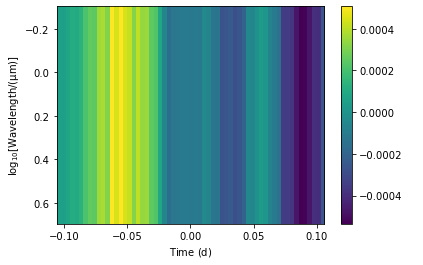

In [167]:
r_systematics.imshow(quantity='systematics_model_from_x');

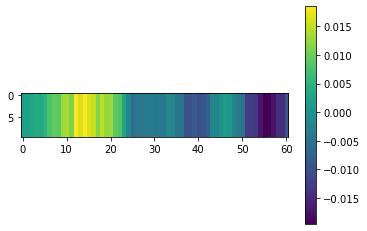

In [176]:
plt.imshow([mean_params['x_p_1'] * r_systematics.x] * 10 )
plt.colorbar()

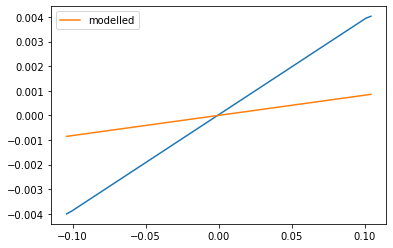

In [160]:
plt.plot(r_systematics.time,r_systematics.systematics_model_from_time[0,:])
plt.plot(r_systematics.time, mean_params['time_p_1'] * r_systematics.time,label='modelled')
plt.legend()

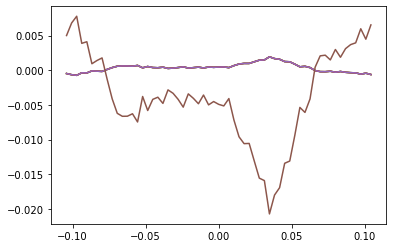

In [161]:
plt.plot(r_systematics.time,r_systematics.systematics_model_from_y[0,:])
plt.plot(r_systematics.time,r_systematics.systematics_model_from_y[1,:])
plt.plot(r_systematics.time,r_systematics.systematics_model_from_y[2,:])
plt.plot(r_systematics.time,r_systematics.systematics_model_from_y[3,:])
plt.plot(r_systematics.time,r_systematics.systematics_model_from_y[4,:])

plt.plot(r_systematics.time, mean_params['y_p_1'] * r_systematics.y)

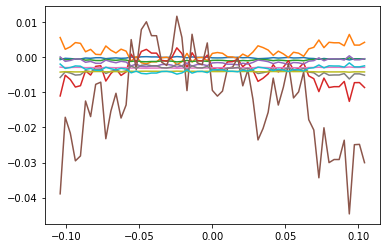

In [162]:
offset = 0
for i in range(r_systematics.nwave):
    plt.plot(r_systematics.time, offset + r_systematics.systematics_model_from_background[i,:])
    plt.plot(r_systematics.time, offset + mean_params[f'background_p_1_w{i}'] * r_systematics.background[i,:])
    offset = offset - 0.001

In [1]:
offset = 0
for i in range(r_systematics.nwave):
    systematics = (r_systematics.systematics_model_from_background[i,:] +\
                    r_systematics.systematics_model_from_x[i,:] +\
                    r_systematics.systematics_model_from_y[i,:] +\
                    r_systematics.systematics_model_from_time[i,:])
    plt.plot(r_systematics.time, offset + systematics)
    
    modelled_systematics = mean_params[f'background_p_1_w{i}'] * r_systematics.background[i,:] + \
                            mean_params['x_p_1'] * r_systematics.x + \
                            mean_params['y_p_1'] * r_systematics.y + \
                            mean_params['time_p_1'] * r_systematics.time.to_value("day")
    plt.plot(r_systematics.time, offset + (modelled_systematics))
    offset = offset - 0.002

NameError: name 'r_systematics' is not defined

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan -3.91863118         nan -3.77097611 -3.6833952
 -3.85400975 -3.85568895 -4.97186226         nan -4.21995474 -3.63027346
 -3.88308211         nan -3.83388219 -5.11616403         nan -3.98151404
         nan         nan         nan         nan         nan -4.50221015
         nan         nan         nan         nan         nan         nan
         nan         nan         nan -5.40531271         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan]
[ 0.03432602 -0.35441686 -0.24001088 -0.09320666 -0.11603932 -0.51376082
 -0.36003543 -0.77680814 -0.82698603 -0.20629889 -0.40860252 -0.61736982
 -0.34781534 -0.46809627         nan -1.35997298         nan         nan
         nan         nan         nan -


🌈 Warning: invalid value encountered in log10
🌈 Warning: invalid value encountered in log10
🌈 Warning: invalid value encountered in log10

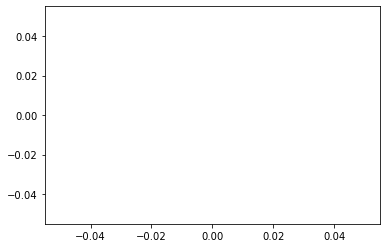

In [142]:
for i in range(r_systematics.nwave):
    print(np.log10(r_systematics.systematics_model_from_background[i,:]))
    print(np.log10(r_systematics.background[i,:]))
    print(r_systematics.background[i,:])
    plt.plot(r_systematics.time, np.log10(r_systematics.systematics_model_from_background[i,:])-np.log10(r_systematics.background[i,:]))

# Create Synthetic Rainbow with Transit

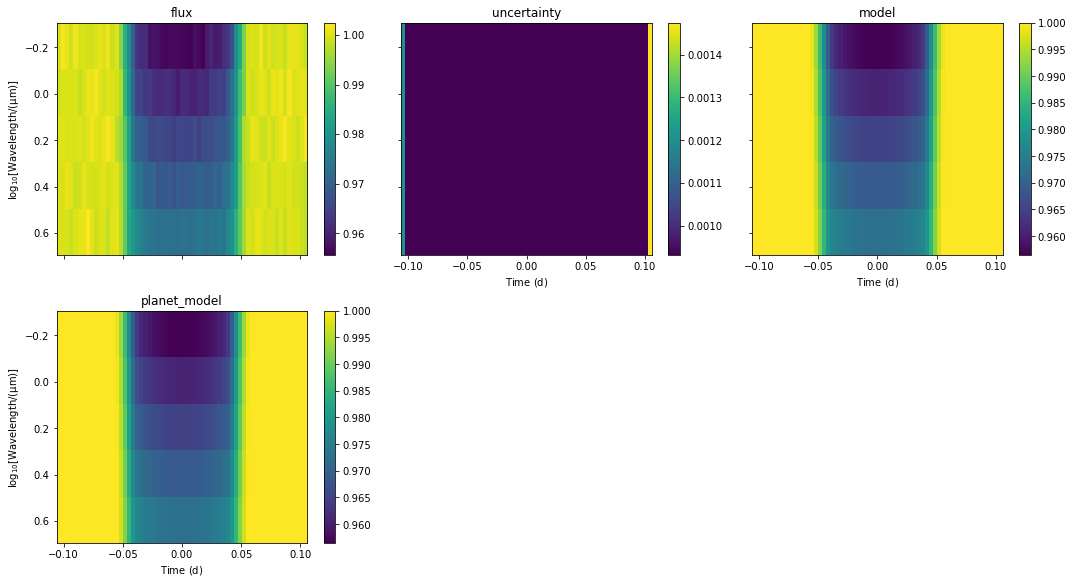

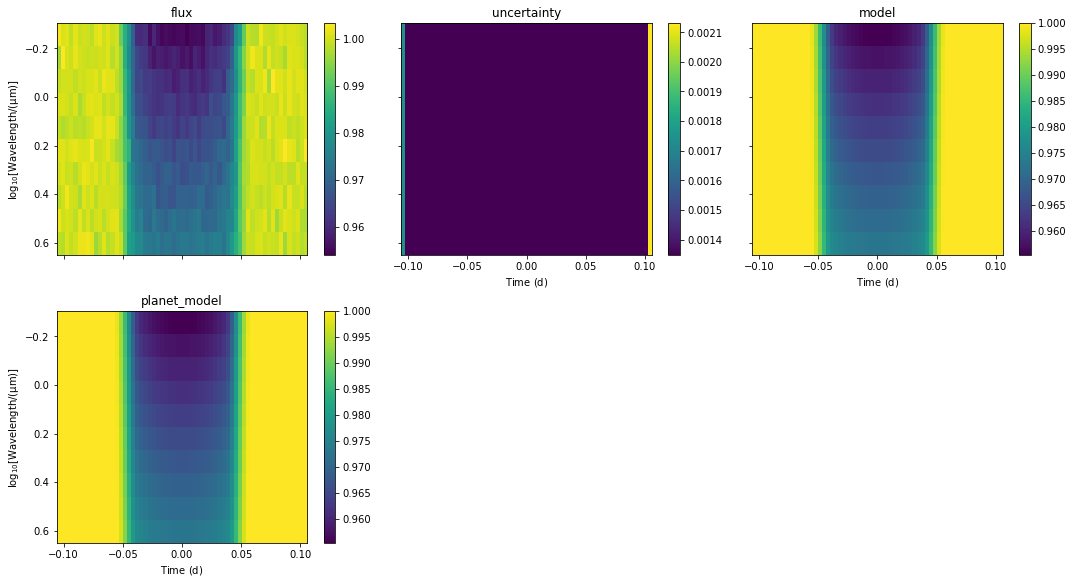

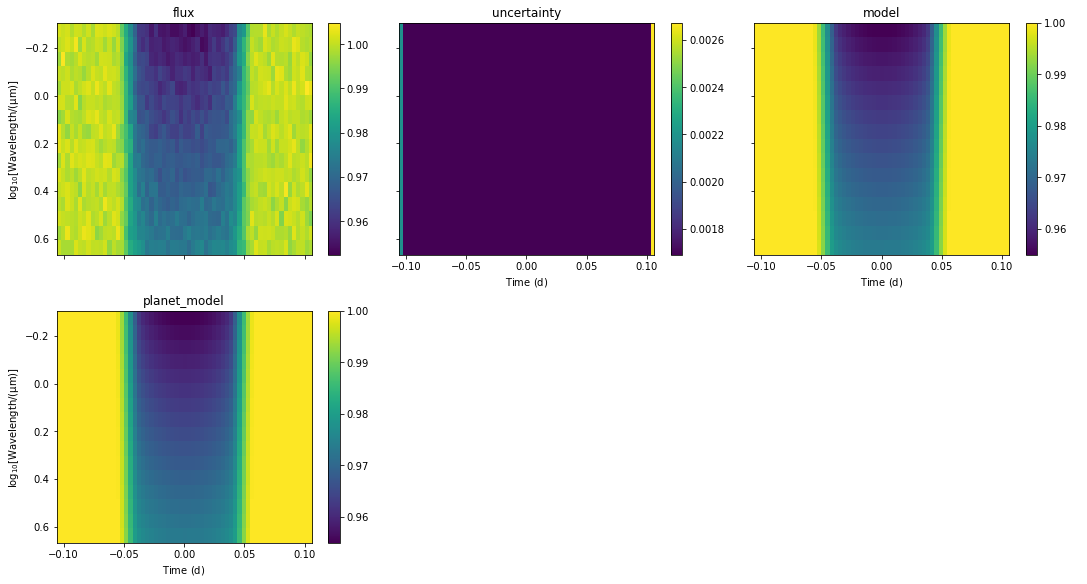

In [2]:
# create polynomial + transit rainbow:

r = SimulatedRainbow(signal_to_noise=100, dt=1 * u.minute, R=50)

# add transit:
r = r.inject_transit(
        c)

# bin:
rbin5 = r.bin(nwavelengths=int(r.nwave/5), dt=5 * u.minute)
rbin10 = r.bin(nwavelengths=int(r.nwave/10), dt=5 * u.minute)
rbin11 = r.bin(nwavelengths=int(r.nwave/11), dt=5 * u.minute)
rbin15 = r.bin(nwavelengths=int(r.nwave/15), dt=5 * u.minute)

rbin5.imshow_quantities();
rbin10.imshow_quantities();
rbin15.imshow_quantities();

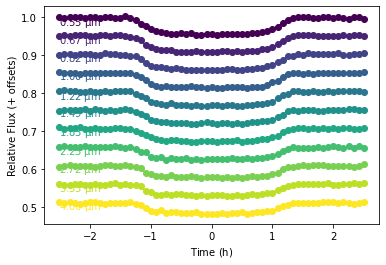

In [223]:
rbin11.plot()

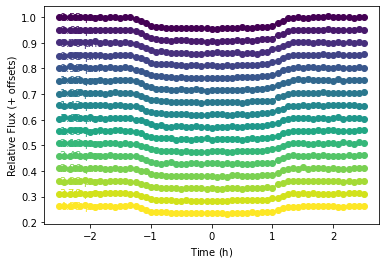

In [170]:
rbin15.plot()

### Try Separate Fitting with Transit Model

In [173]:
t = TransitModel()
t.initialize_empty_model()

t.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
                )

t.summarize_parameters()

t.attach_data(rbin15)

# t.choose_optimization_method("separate")
# print(t.optimization)

t.setup_lightcurves()

t.setup_likelihood()
print(t.pymc3_model[3])

stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_radius') 🧮>

stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_mass') 🧮>

radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

period =
  <🧮 Fixed | 1 🧮>

epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='epoch') 🧮>

baseline =
  <🧮 Fitted Uniform(lower=0.95, upper=1.05, name='baseline') 🧮>

impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='impact_parameter') 🧮>

limb_darkening =
  <🧮 Fitted QuadLimbDark(testval=[0.05, 0.35], name='limb_darkening') 🧮>



100%|███████████████████████████████████████| 16/16 [00:00<00:00, 161319.38it/s]


             epoch_w3_interval__ ~ TransformedDistribution
    impact_parameter_w3_impact__ ~ TransformedDistribution
    stellar_radius_w3_interval__ ~ TransformedDistribution
      stellar_mass_w3_interval__ ~ TransformedDistribution
limb_darkening_w3_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w3 ~ Normal
          baseline_w3_interval__ ~ TransformedDistribution
                        epoch_w3 ~ Uniform
             impact_parameter_w3 ~ ImpactParameter
               stellar_radius_w3 ~ Uniform
                 stellar_mass_w3 ~ Uniform
               limb_darkening_w3 ~ QuadLimbDark
                     baseline_w3 ~ Uniform
               wavelength_3_data ~ Normal



🌈 Warning: invalid value encountered in log

KeyError: 'wavelength_1_data'

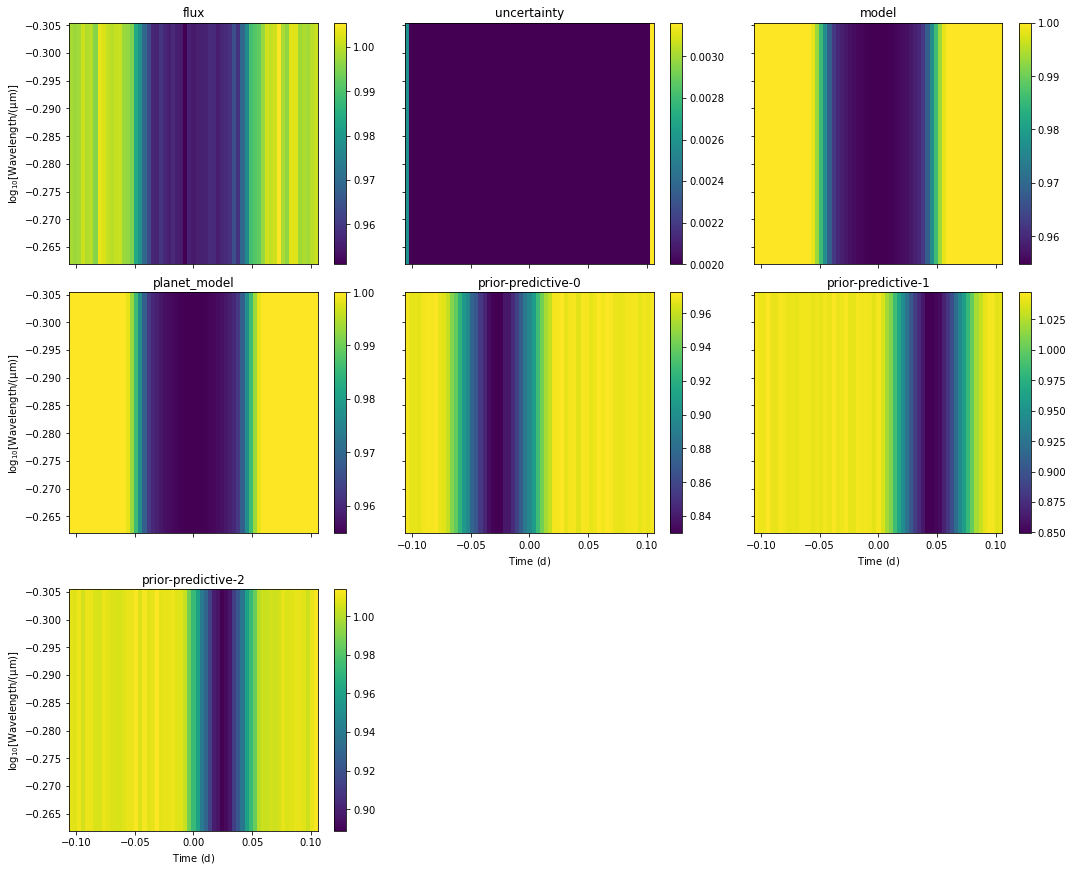

In [155]:
t.plot_priors()

In [174]:
t.sample()
t.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w0, radius_ratio_w0, limb_darkening_w0, stellar_mass_w0, stellar_radius_w0, impact_parameter_w0, epoch_w0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w1, radius_ratio_w1, limb_darkening_w1, stellar_mass_w1, stellar_radius_w1, impact_parameter_w1, epoch_w1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w2, radius_ratio_w2, limb_darkening_w2, stellar_mass_w2, stellar_radius_w2, impact_parameter_w2, epoch_w2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7912243491041353, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w3, radius_ratio_w3, limb_darkening_w3, stellar_mass_w3, stellar_radius_w3, impact_parameter_w3, epoch_w3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w4, radius_ratio_w4, limb_darkening_w4, stellar_mass_w4, stellar_radius_w4, impact_parameter_w4, epoch_w4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w5, radius_ratio_w5, limb_darkening_w5, stellar_mass_w5, stellar_radius_w5, impact_parameter_w5, epoch_w5]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w6, radius_ratio_w6, limb_darkening_w6, stellar_mass_w6, stellar_radius_w6, impact_parameter_w6, epoch_w6]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8386306645075874, but should be close to 0.9. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w7, radius_ratio_w7, limb_darkening_w7, stellar_mass_w7, stellar_radius_w7, impact_parameter_w7, epoch_w7]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w8, radius_ratio_w8, limb_darkening_w8, stellar_mass_w8, stellar_radius_w8, impact_parameter_w8, epoch_w8]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.959667148121824, but should be close to 0.9. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w9, radius_ratio_w9, limb_darkening_w9, stellar_mass_w9, stellar_radius_w9, impact_parameter_w9, epoch_w9]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w10, radius_ratio_w10, limb_darkening_w10, stellar_mass_w10, stellar_radius_w10, impact_parameter_w10, epoch_w10]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w11, radius_ratio_w11, limb_darkening_w11, stellar_mass_w11, stellar_radius_w11, impact_parameter_w11, epoch_w11]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w12, radius_ratio_w12, limb_darkening_w12, stellar_mass_w12, stellar_radius_w12, impact_parameter_w12, epoch_w12]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 372 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.814649859874806, but should be close to 0.9. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w13, radius_ratio_w13, limb_darkening_w13, stellar_mass_w13, stellar_radius_w13, impact_parameter_w13, epoch_w13]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 506 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w14, radius_ratio_w14, limb_darkening_w14, stellar_mass_w14, stellar_radius_w14, impact_parameter_w14, epoch_w14]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2694 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w15, radius_ratio_w15, limb_darkening_w15, stellar_mass_w15, stellar_radius_w15, impact_parameter_w15, epoch_w15]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1811 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9630559924757301, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.



🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

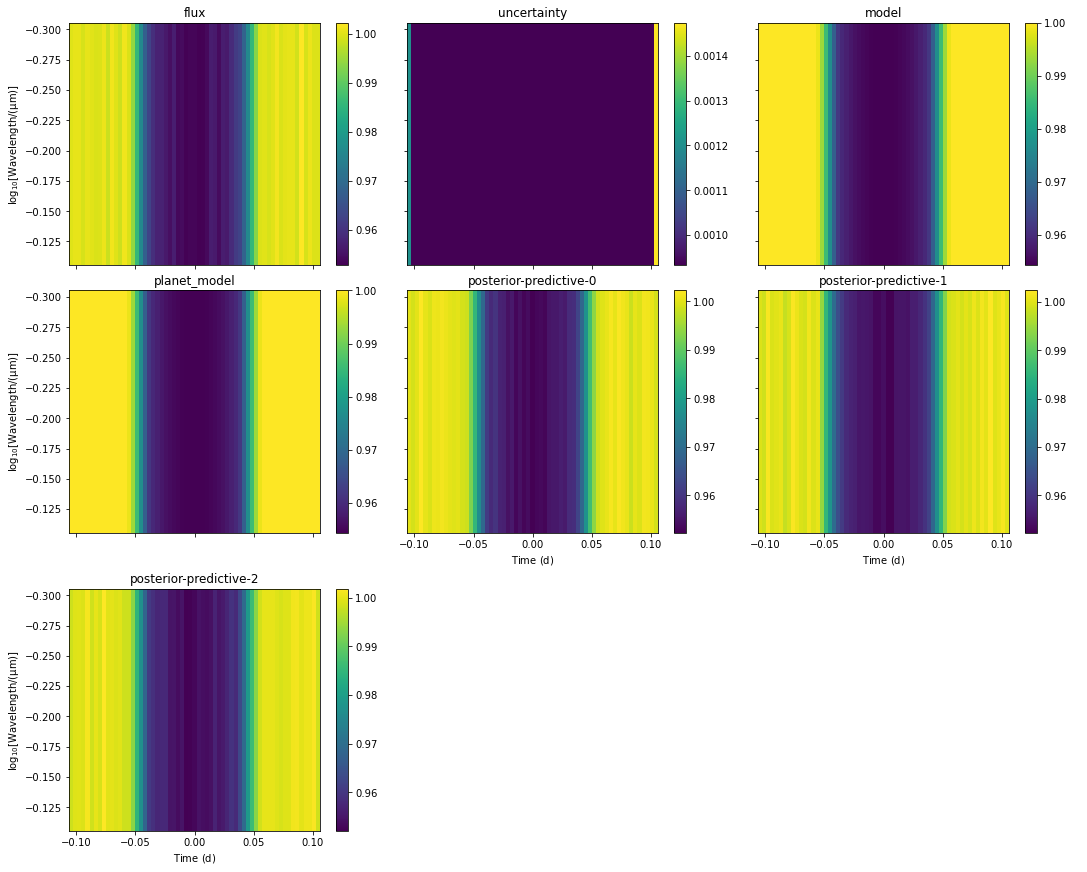

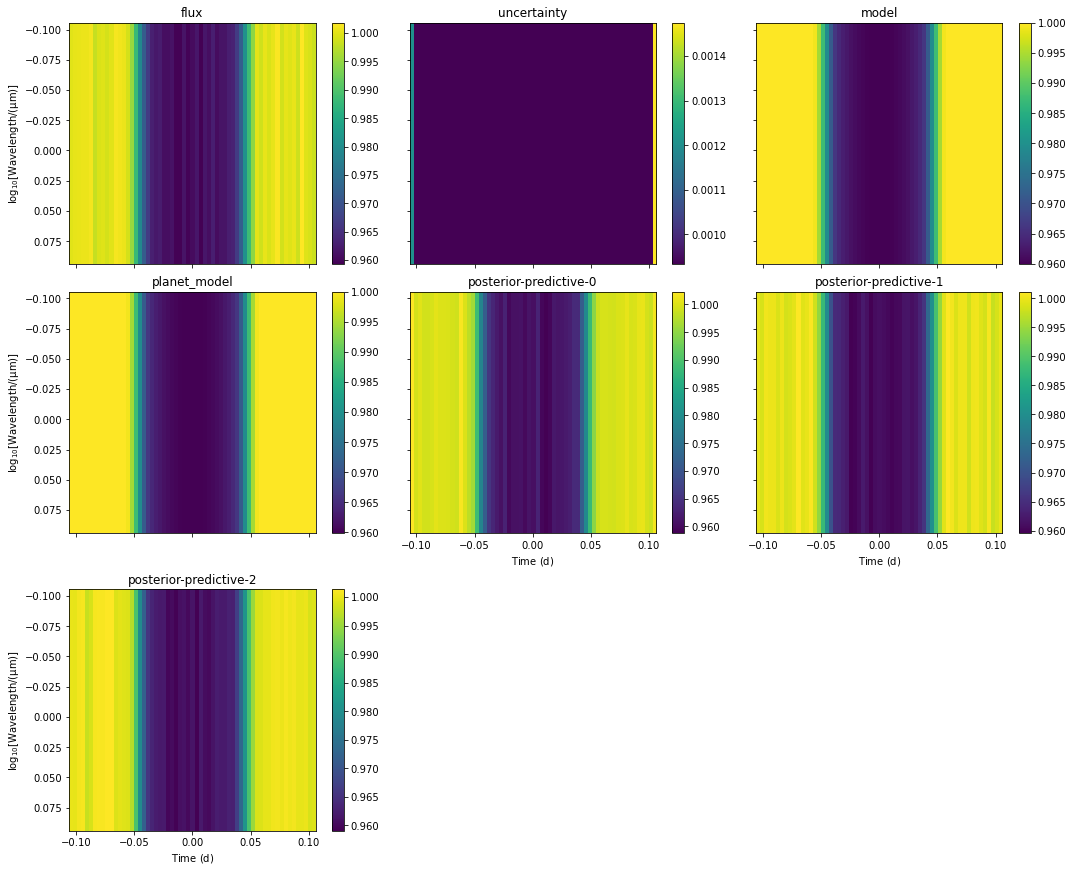

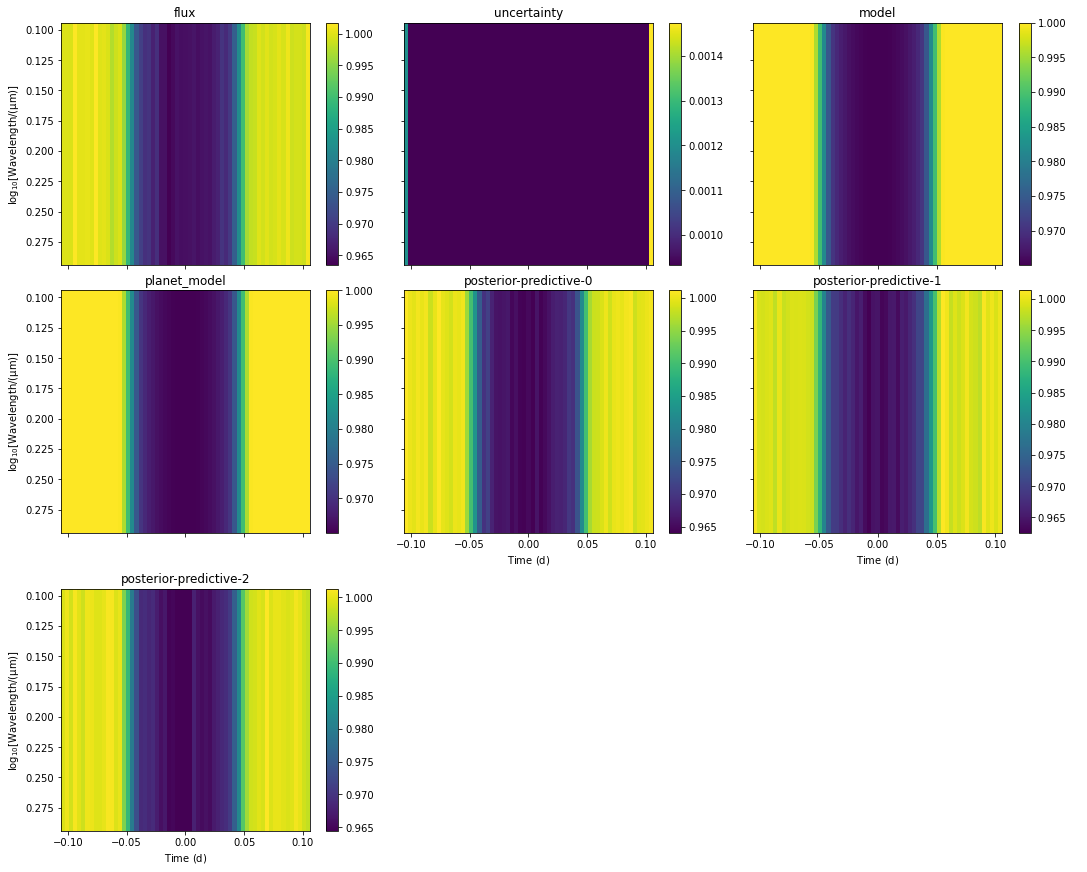

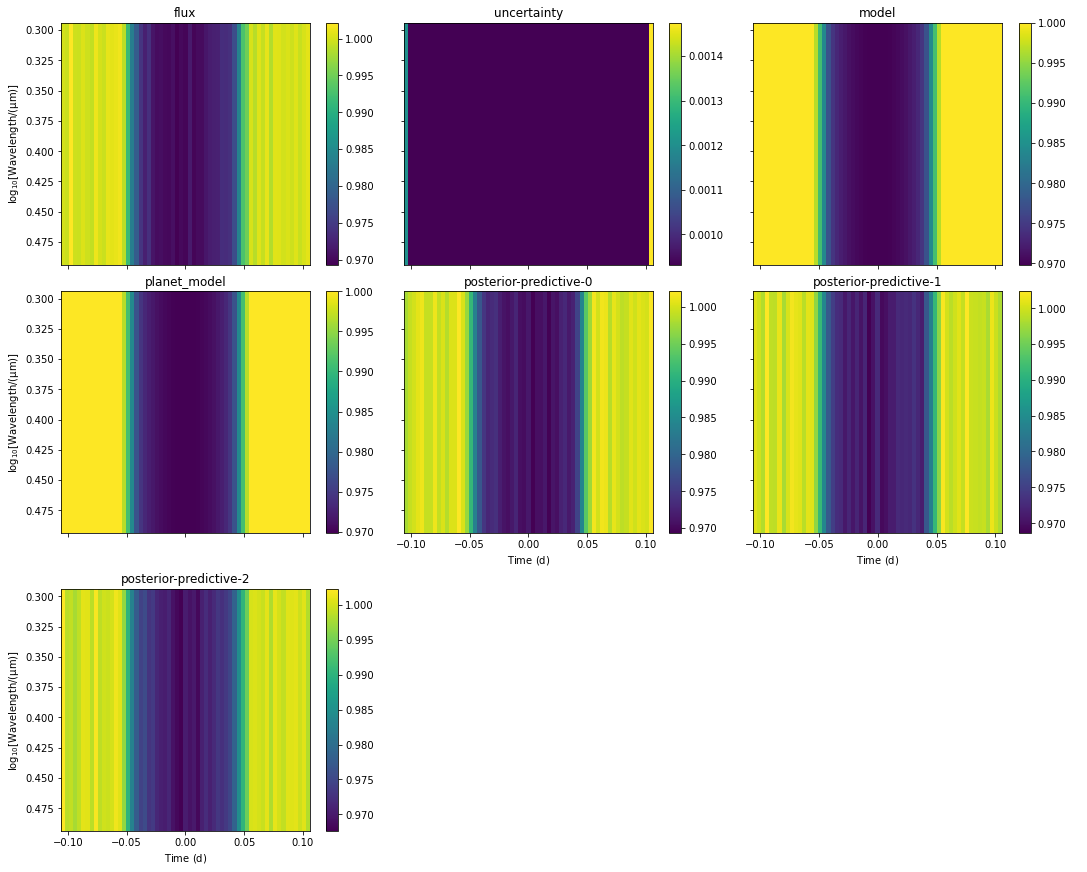

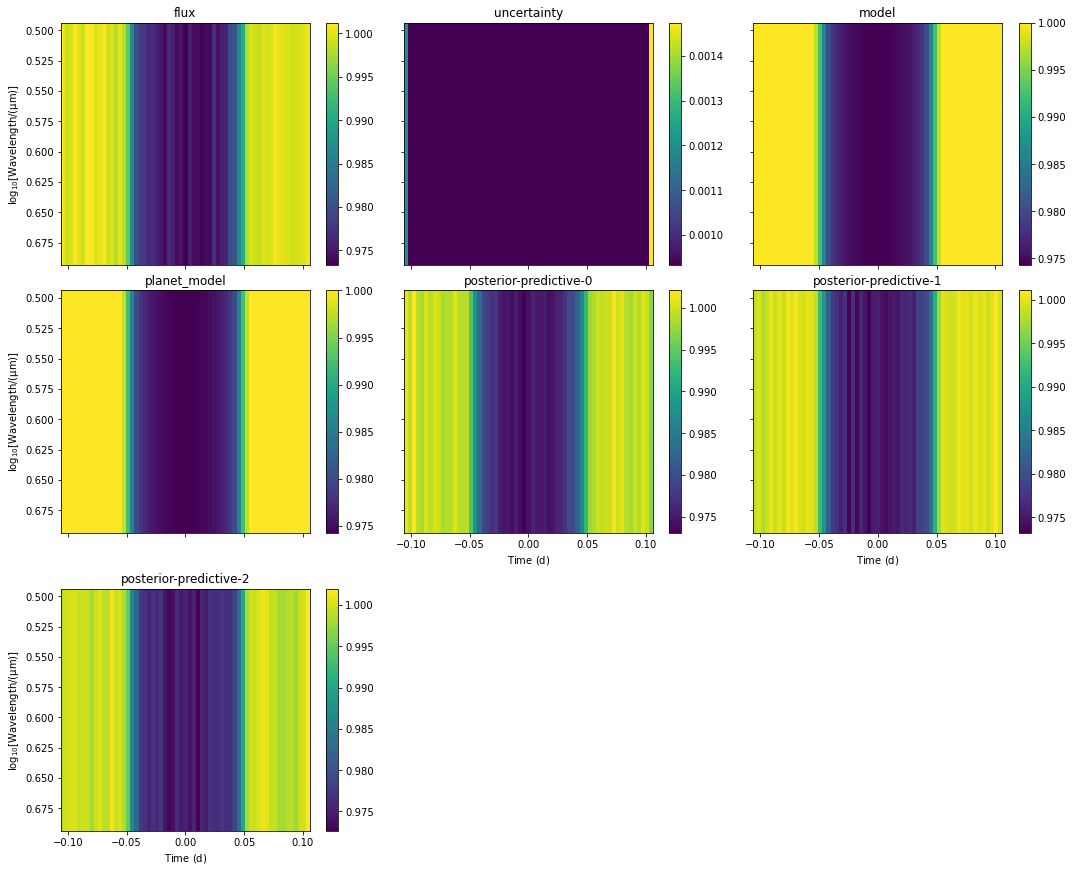

In [30]:
t.plot_posteriors()

In [14]:
def plot_2d_lightcurves(self):
    fig, ax = plt.subplots(figsize=(7,7))
    from matplotlib.pyplot import cm as cmap

    posterior_predictive_traces = self.sample_posterior(ndraws=50)

    for j, (mod, trace, summary, posterior_predictive_trace) in enumerate(zip(self.pymc3_model, self.trace, self.summary, posterior_predictive_traces)):
        if self.optimization == 'separate':
            data = self.get_data(j)
            spacing = 3 * np.nanstd(self.get_data(0).flux)
        else:
            data = self.get_data()
            spacing = 3 * np.nanstd(data.flux)

        color=cmap.viridis(np.linspace(0,1,data.nwave))

        posterior_means = summary['mean']

        # spacing = ax._most_recent_chromatic_plot_spacing
        for i, w in enumerate(data.wavelength):
            firstplot = True
            transit_params = self.extract_mean_posteriors(summary, i+j)
            transit = self.transit_model(transit_params)
            poly = []
#             transit_params = self.chromatic_models['transit'].extract_mean_posteriors(summary, i+j)#cm.chromatic_models['transit'].extract_mean_posteriors(summary, i+j)
#             poly_params = self.chromatic_models['polynomial'].extract_mean_posteriors(summary, i+j)#cm.chromatic_models['polynomial'].extract_mean_posteriors(summary, i+j)

#             poly = self.chromatic_models['polynomial'].polynomial_model(poly_params)
#             transit = self.chromatic_models['transit'].transit_model(transit_params)

            for k in range(50):
                if firstplot:
                    plt.plot(data.time, (-spacing*(i+j)) + posterior_predictive_trace[f'wavelength_{i+j}_data'][k],color='gray',alpha=0.3,label='Posterior Sample (n=50)')
                    firstplot=False
                else:
                    plt.plot(data.time, (-spacing*(i+j)) + posterior_predictive_trace[f'wavelength_{i+j}_data'][k],color='gray',alpha=0.3)

            plt.plot(data.time,(transit) + (-spacing*(i+j)),color='cyan')
            plt.plot(data.time, data.flux[i] + (-spacing*(i+j)),'.')
            plt.text(data.time[0].to_value(), data.flux[i][0] + (-spacing*(i+j)) + 0.01, s="%.2f"%w.to_value())

    plt.title(self.optimization)
    plt.ylabel("Relative Flux + offset")
    plt.xlabel("Time from Transit Epoch")
    plt.legend(loc='lower right',fontsize=8)
    plt.show()
    plt.close()
    


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

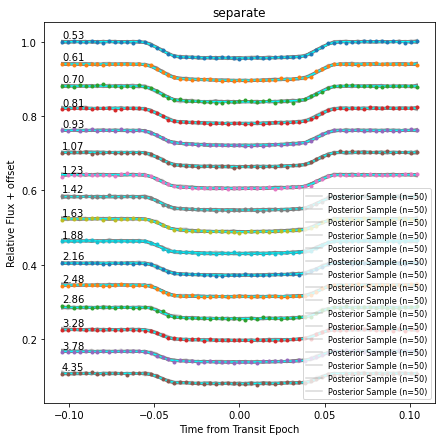

In [175]:
plot_2d_lightcurves(t)

## Try White Light Fit

In [187]:
# need to reinitialise model due to known issue with separate wavelength-fitting
t3 = TransitModel()
t3.initialize_empty_model()

t3.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
                )

t3.summarize_parameters()

t3.attach_data(r)

t3.choose_optimization_method("white_light")
# print(t.optimization)

t3.setup_lightcurves()

t3.setup_likelihood()
print(t3.pymc3_model)

stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_radius') 🧮>

stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_mass') 🧮>

radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

period =
  <🧮 Fixed | 1 🧮>

epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='epoch') 🧮>

baseline =
  <🧮 Fitted Uniform(lower=0.95, upper=1.05, name='baseline') 🧮>

impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='impact_parameter') 🧮>

limb_darkening =
  <🧮 Fitted QuadLimbDark(testval=[0.05, 0.35], name='limb_darkening') 🧮>




🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5356.71it/s]

🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars

             epoch_interval__ ~ TransformedDistribution
    impact_parameter_impact__ ~ TransformedDistribution
    stellar_radius_interval__ ~ TransformedDistribution
      stellar_mass_interval__ ~ TransformedDistribution
limb_darkening_quadlimbdark__ ~ TransformedDistribution
              radius_ratio_w0 ~ Normal
          baseline_interval__ ~ TransformedDistribution
                        epoch ~ Uniform
             impact_parameter ~ ImpactParameter
               stellar_radius ~ Uniform
                 stellar_mass ~ Uniform
               limb_darkening ~ QuadLimbDark
                     baseline ~ Uniform
            wavelength_0_data ~ Normal


In [188]:
t3.sample()
t3.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, radius_ratio_w0, limb_darkening, stellar_mass, stellar_radius, impact_parameter, epoch]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [192]:
t3.summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
radius_ratio_w0,0.177409,0.000715,0.176024,0.178721,0.000017,0.000012,1803.050895,1922.645714,1.004452
epoch,-0.000069,0.000073,-0.000207,0.000072,0.000001,0.000001,2788.737116,2269.855725,1.002583
impact_parameter,0.063515,0.045767,0.000055,0.144920,0.000979,0.000692,1748.298423,1272.132321,1.001087
stellar_radius,1.176455,0.014171,1.153581,1.199966,0.000573,0.000406,519.165176,521.850315,1.005287
stellar_mass,0.854653,0.031059,0.802632,0.905478,0.001231,0.000871,575.402167,544.593746,1.004716
limb_darkening[0],0.333350,0.050967,0.241131,0.426632,0.001213,0.000878,1667.818918,1937.405931,1.006394
limb_darkening[1],0.005716,0.111247,-0.189156,0.205616,0.003017,0.002134,1317.275840,1358.853331,1.007104
baseline,1.000090,0.000078,0.999937,1.000231,0.000002,0.000001,2584.366898,2282.635961,1.003050


NameError: name 't3' is not defined

### Try a Separate Wavelength fit using White Light Fitted Parameters

In [194]:
t4 = TransitModel()
t4.initialize_empty_model()

t4.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=wl.results['period'],
                   epoch=WavelikeFitted(mu=wl.results['epoch'],sigma=wl.results['epoch_lower_error']),
                   stellar_radius = 1.176455,
                   stellar_mass =0.854653,
                   radius_ratio=WavelikeFitted(Normal, mu=0.177409, sigma=0.05),
                   impact_parameter=0.063515,
                   limb_darkening=WavelikeFitted(QuadLimbDark,testval=[0.333350,0.005716]),
                    baseline = WavelikeFitted(Normal, mu=1.000090, sigma=0.000078)
                )

t4.summarize_parameters()

t4.attach_data(rbin15)

t4.choose_optimization_method("separate")
# print(t.optimization)

t4.setup_lightcurves()

t4.setup_likelihood()
print(t.pymc3_model[3])

stellar_radius =
  <🧮 Fixed | 1.176455 🧮>

stellar_mass =
  <🧮 Fixed | 0.854653 🧮>

radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.177409, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

period =
  <🧮 Fixed | 1 🧮>

epoch =
  <🧮 Fixed | -6.9e-05 🧮>

baseline =
  <🧮 WavelikeFitted Normal(mu=1.00009, sigma=7.8e-05, name='baseline') for each wavelength 🧮>

impact_parameter =
  <🧮 Fixed | 0.063515 🧮>

limb_darkening =
  <🧮 WavelikeFitted QuadLimbDark(testval=[0.33335, 0.005716], name='limb_darkening') for each wavelength 🧮>



100%|███████████████████████████████████████| 16/16 [00:00<00:00, 280790.23it/s]


             epoch_w3_interval__ ~ TransformedDistribution
    impact_parameter_w3_impact__ ~ TransformedDistribution
    stellar_radius_w3_interval__ ~ TransformedDistribution
      stellar_mass_w3_interval__ ~ TransformedDistribution
limb_darkening_w3_quadlimbdark__ ~ TransformedDistribution
                 radius_ratio_w3 ~ Normal
          baseline_w3_interval__ ~ TransformedDistribution
                        epoch_w3 ~ Uniform
             impact_parameter_w3 ~ ImpactParameter
               stellar_radius_w3 ~ Uniform
                 stellar_mass_w3 ~ Uniform
               limb_darkening_w3 ~ QuadLimbDark
                     baseline_w3 ~ Uniform
               wavelength_3_data ~ Normal


In [195]:
t4.sample()
t4.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w0, radius_ratio_w0, limb_darkening_w0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w1, radius_ratio_w1, limb_darkening_w1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w2, radius_ratio_w2, limb_darkening_w2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.9604957841183012, but should be close to 0.9. Try to increase the number of tuning steps.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w3, radius_ratio_w3, limb_darkening_w3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w4, radius_ratio_w4, limb_darkening_w4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w5, radius_ratio_w5, limb_darkening_w5]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The acceptance probability does not match the target. It is 0.9594808968757367, but should be close to 0.9. Try to increase the number of tuning steps.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w6, radius_ratio_w6, limb_darkening_w6]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.966613177428861, but should be close to 0.9. Try to increase the number of tuning steps.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w7, radius_ratio_w7, limb_darkening_w7]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.9657320912180892, but should be close to 0.9. Try to increase the number of tuning steps.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w8, radius_ratio_w8, limb_darkening_w8]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w9, radius_ratio_w9, limb_darkening_w9]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w10, radius_ratio_w10, limb_darkening_w10]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w11, radius_ratio_w11, limb_darkening_w11]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w12, radius_ratio_w12, limb_darkening_w12]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w13, radius_ratio_w13, limb_darkening_w13]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w14, radius_ratio_w14, limb_darkening_w14]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.

🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_w15, radius_ratio_w15, limb_darkening_w15]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


## Try Simultaneous Transit Fit 

In [227]:
# need to reinitialise model due to known issue with separate wavelength-fitting
t2 = TransitModel()
t2.initialize_empty_model()

t2.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.99, upper=1.01,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.99, upper=1.01,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.17, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.2,testval=0.44),
                   limb_darkening=WavelikeFitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = WavelikeFitted(Uniform, lower=0.99,upper=1.01)
                )

t2.summarize_parameters()

t2.attach_data(rbin11)

t2.choose_optimization_method("simultaneous")

t2.setup_lightcurves()

t2.setup_likelihood()
print(t2.pymc3_model)

stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_radius') 🧮>

stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='stellar_mass') 🧮>

radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.5, sigma=0.05, name='radius_ratio') for each wavelength 🧮>

period =
  <🧮 Fixed | 1 🧮>

epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='epoch') 🧮>

baseline =
  <🧮 WavelikeFitted Uniform(lower=0.95, upper=1.05, name='baseline') for each wavelength 🧮>

impact_parameter =
  <🧮 Fitted ImpactParameter(ror=0.15, testval=0.44, name='impact_parameter') 🧮>

limb_darkening =
  <🧮 WavelikeFitted QuadLimbDark(testval=[0.05, 0.35], name='limb_darkening') for each wavelength 🧮>



100%|████████████████████████████████████████| 11/11 [00:00<00:00, 58848.65it/s]


                 epoch_interval__ ~ TransformedDistribution
        impact_parameter_impact__ ~ TransformedDistribution
        stellar_radius_interval__ ~ TransformedDistribution
          stellar_mass_interval__ ~ TransformedDistribution
 limb_darkening_w0_quadlimbdark__ ~ TransformedDistribution
                  radius_ratio_w0 ~ Normal
           baseline_w0_interval__ ~ TransformedDistribution
 limb_darkening_w1_quadlimbdark__ ~ TransformedDistribution
                  radius_ratio_w1 ~ Normal
           baseline_w1_interval__ ~ TransformedDistribution
 limb_darkening_w2_quadlimbdark__ ~ TransformedDistribution
                  radius_ratio_w2 ~ Normal
           baseline_w2_interval__ ~ TransformedDistribution
 limb_darkening_w3_quadlimbdark__ ~ TransformedDistribution
                  radius_ratio_w3 ~ Normal
           baseline_w3_interval__ ~ TransformedDistribution
 limb_darkening_w4_quadlimbdark__ ~ TransformedDistribution
                  radius_ratio_w4 ~ Normal
     


🌈 Warning: invalid value encountered in log

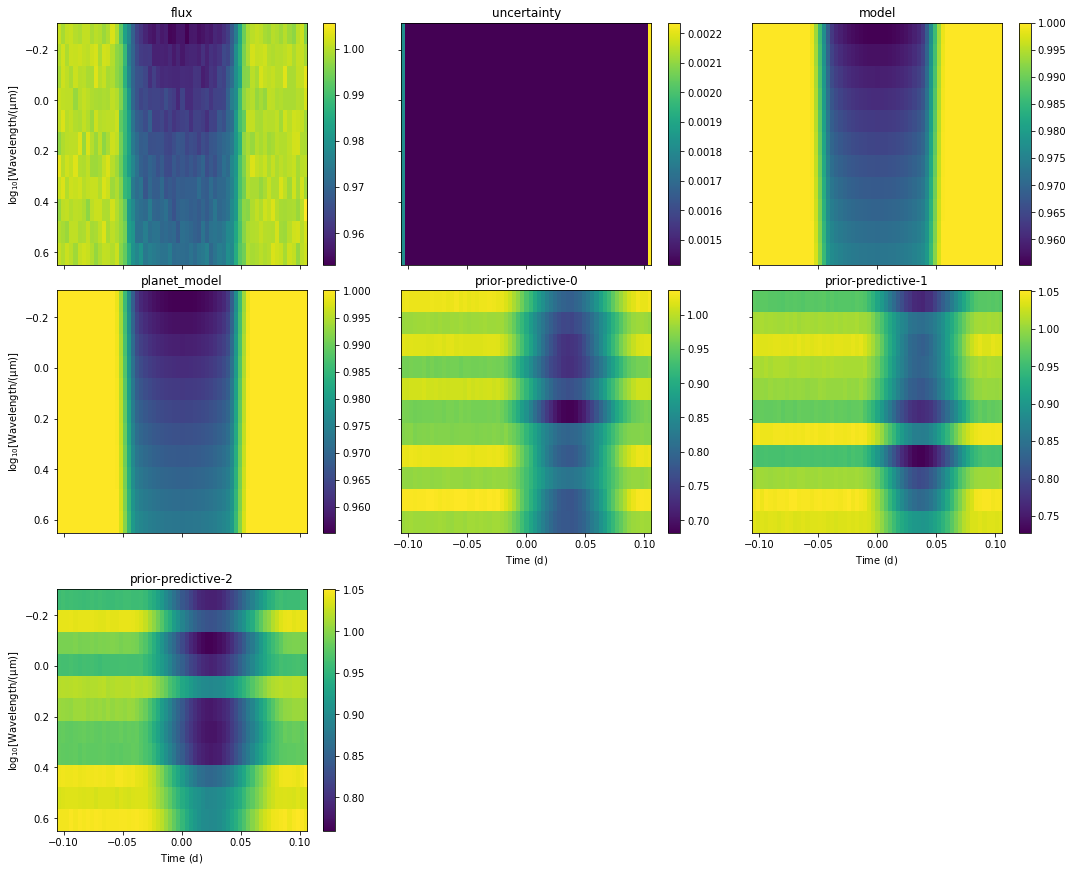

In [228]:
t2.plot_priors()

In [229]:
t2.sample(tune=12000, draws=12000, cores=12, chains=4)
t2.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [baseline_w10, radius_ratio_w10, limb_darkening_w10, baseline_w9, radius_ratio_w9, limb_darkening_w9, baseline_w8, radius_ratio_w8, limb_darkening_w8, baseline_w7, radius_ratio_w7, limb_darkening_w7, baseline_w6, radius_ratio_w6, limb_darkening_w6, baseline_w5, radius_ratio_w5, limb_darkening_w5, baseline_w4, radius_ratio_w4, limb_darkening_w4, baseline_w3, radius_ratio_w3, limb_darkening_w3, baseline_w2, radius_ratio_w2, limb_darkening_w2, baseline_w1, radius_ratio_w1, limb_darkening_w1, baseline_w0, radius_ratio_w0, limb_darkening_w0, stellar_mass, stellar_radius, impact_parameter, epoch]


Sampling 4 chains for 12_000 tune and 12_000 draw iterations (48_000 + 48_000 draws total) took 70549 seconds.
There were 215 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8968 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8174829279137645, but should be close to 0.9. Try to increase the number of tuning steps.
There were 418 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1994 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8109223724383543, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [231]:
t2.summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
radius_ratio_w0,0.343375,0.288988,0.190919,0.967714,0.126450,0.094944,18.746893,26.472280,1.522909
radius_ratio_w1,0.443201,0.494038,0.176985,1.510931,0.215867,0.162053,19.536180,26.472280,1.528078
radius_ratio_w2,-0.053327,0.484881,-1.102343,0.224099,0.210971,0.158292,19.957102,26.472280,1.526978
radius_ratio_w3,-0.041098,0.443272,-0.999162,0.198539,0.193642,0.145365,19.439783,26.472280,1.528747
radius_ratio_w4,0.388201,0.410873,0.172614,1.275789,0.179847,0.135044,18.829784,26.472280,1.523354
radius_ratio_w5,0.168190,0.011010,0.144243,0.176712,0.004844,0.003644,8.422720,26.472280,1.393388
radius_ratio_w6,-0.085488,0.513802,-1.196401,0.198316,0.224120,0.168212,19.463672,26.472280,1.527366
radius_ratio_w7,0.177412,0.018269,0.165167,0.220864,0.007123,0.005369,21.339581,26.472280,1.526476
radius_ratio_w8,0.057250,0.213627,-0.404981,0.180550,0.092887,0.069687,20.036543,26.472280,1.524912
radius_ratio_w9,0.063121,0.190431,-0.347572,0.164593,0.083498,0.062711,9.202465,26.472280,1.345262



🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

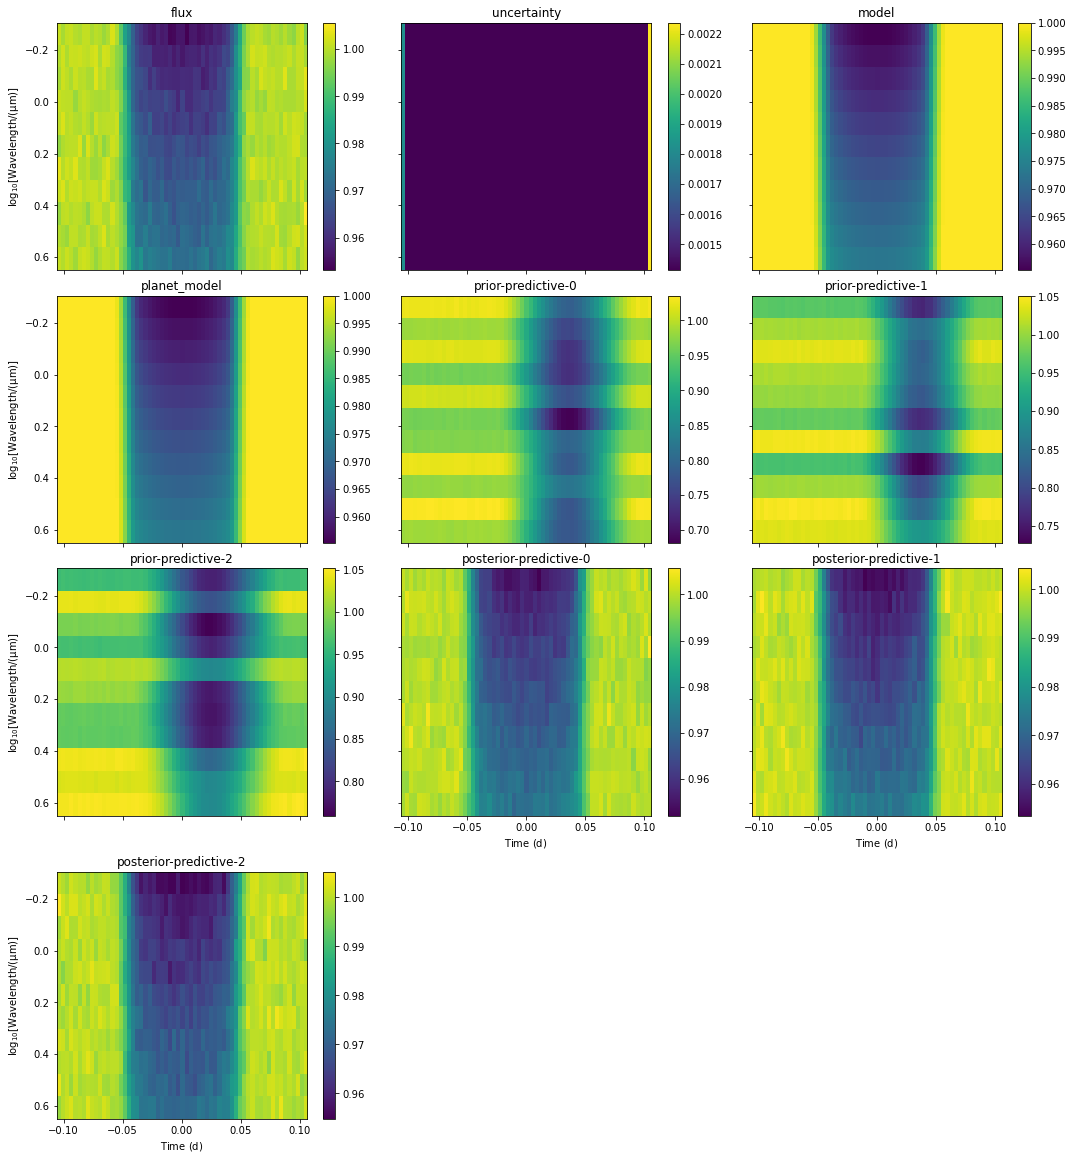

In [232]:
t2.plot_posteriors()

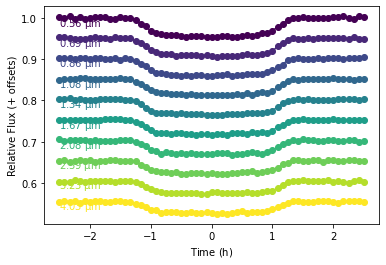

In [216]:
t2.plot_lightcurves(trace=t2.trace)

In [217]:
t2.summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
radius_ratio_w0,0.200542,0.001345,0.198022,0.203081,6.900000e-06,4.900000e-06,37722.498904,32307.392297,1.000069
radius_ratio_w1,0.194208,0.001384,0.191654,0.196850,7.000000e-06,5.000000e-06,38840.829569,29531.017001,1.000163
radius_ratio_w2,0.190389,0.001377,0.187811,0.192969,6.900000e-06,4.900000e-06,40139.713119,30338.222998,0.999982
radius_ratio_w3,0.185616,0.001335,0.183162,0.188193,6.500000e-06,4.600000e-06,41826.117910,32148.491279,1.000056
radius_ratio_w4,0.180203,0.001347,0.177631,0.182725,6.400000e-06,4.500000e-06,44482.433789,30089.262606,1.000188
radius_ratio_w5,0.176078,0.001358,0.173540,0.178638,6.400000e-06,4.600000e-06,44439.573133,32509.039509,1.000065
radius_ratio_w6,0.170698,0.001465,0.167884,0.173388,6.800000e-06,4.800000e-06,46196.861876,34774.603777,1.000125
radius_ratio_w7,0.164429,0.001439,0.161710,0.167102,7.000000e-06,4.900000e-06,42744.476547,32630.462647,1.000035
radius_ratio_w8,0.160690,0.001501,0.157932,0.163568,6.800000e-06,4.800000e-06,48957.708592,31833.993228,1.000071
radius_ratio_w9,0.155106,0.001521,0.152246,0.157945,7.000000e-06,5.000000e-06,46604.318526,31208.892537,1.000055


## Compare Simultaneous and Separate Fits

In [202]:
def plot_transmisison_spectrum(self,ax=None, model=None,**kw):
    if ax is None:
        ax = plt.subplot()
    plt.sca(ax)
    ws, rr, drr = [],[],[]
    
    if self.optimization == "separate":
        summaries = self.summary
        datas = [self.get_data(i) for i in range(self.data.nwave)]
        wavelengths = [d.wavelength[0] for d in datas]
    else:
        summaries = [self.summary]
        datas = [self.get_data()]
        wavelengths = [self.get_data().wavelength]
        
    for i, (summary, data, wavelength) in enumerate(zip(summaries, datas, wavelengths)):
        posterior_means = summary['mean']
        posterior_sd = summary['sd']
        for w, wav in enumerate(data.wavelength):
            ws.append(wav.to_value())
            if "radius_ratio" in posterior_means.index:
                rr.append(posterior_means["radius_ratio"])
                drr.append(posterior_sd["radius_ratio"])
            elif f"radius_ratio_w{i+w}" in posterior_means.index:
                rr.append(posterior_means[f"radius_ratio_w{i+w}"])
                drr.append(posterior_sd[f"radius_ratio_w{i+w}"])
                
    if model is not None:
        plt.plot(model['wavelength'],model['rr'],'k',alpha=0.3,label="Model Spectrum")
                
    plt.errorbar(ws,rr,drr,alpha=0.5,capsize=5,linestyle='None',c='gray')
    plt.plot(ws,rr,'.',markersize=8,**kw)
    plt.title("Transmission Spectrum")
    plt.ylabel("Rp/R*")
    plt.xlabel("Wavelength")
    plt.legend()



🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: Mean of empty slice.
🌈 Warning: invalid value encountered in double_scalars

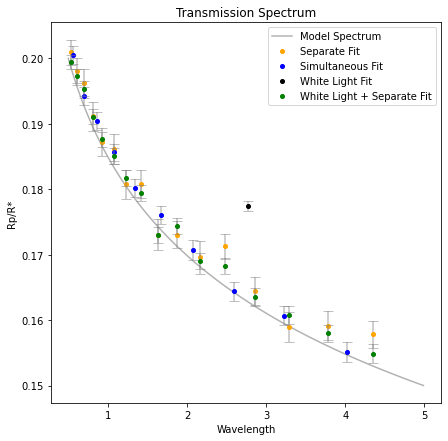

In [221]:
fig, ax = plt.subplots(figsize=(7,7))
# model = {'wavelength':np.logspace(np.log10(r.wavelength[0].to_value()),np.log10(r.wavelength[-1].to_value()),100),'rr':np.linspace(0.2, 0.15, 100)}
model = {'wavelength':r.wavelength,'rr':np.linspace(0.2, 0.15, r.nwave)}
# model2 = {'wavelength':rbin10.wavelength,'rr':np.linspace(0.2, 0.15, rbin10.nwave)}
plot_transmisison_spectrum(t, ax, model=model, color="orange",label="Separate Fit")
plot_transmisison_spectrum(t2, ax, color='blue', label="Simultaneous Fit")
plot_transmisison_spectrum(t3, ax, color='k', label="White Light Fit")
plot_transmisison_spectrum(t4, ax, color='green', label="White Light + Separate Fit")

In [230]:
t2.summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
radius_ratio_w0,0.343375,0.288988,0.190919,0.967714,0.126450,0.094944,18.746893,26.472280,1.522909
radius_ratio_w1,0.443201,0.494038,0.176985,1.510931,0.215867,0.162053,19.536180,26.472280,1.528078
radius_ratio_w2,-0.053327,0.484881,-1.102343,0.224099,0.210971,0.158292,19.957102,26.472280,1.526978
radius_ratio_w3,-0.041098,0.443272,-0.999162,0.198539,0.193642,0.145365,19.439783,26.472280,1.528747
radius_ratio_w4,0.388201,0.410873,0.172614,1.275789,0.179847,0.135044,18.829784,26.472280,1.523354
radius_ratio_w5,0.168190,0.011010,0.144243,0.176712,0.004844,0.003644,8.422720,26.472280,1.393388
radius_ratio_w6,-0.085488,0.513802,-1.196401,0.198316,0.224120,0.168212,19.463672,26.472280,1.527366
radius_ratio_w7,0.177412,0.018269,0.165167,0.220864,0.007123,0.005369,21.339581,26.472280,1.526476
radius_ratio_w8,0.057250,0.213627,-0.404981,0.180550,0.092887,0.069687,20.036543,26.472280,1.524912
radius_ratio_w9,0.063121,0.190431,-0.347572,0.164593,0.083498,0.062711,9.202465,26.472280,1.345262


## Add polynomial

In [2]:
r = SimulatedRainbow(signal_to_noise=100, dt=1 * u.minute, R=50)
r.timelike['x'] = np.linspace(-5,5,r.ntime) + [np.random.normal(0, 2) for c in range(r.ntime)]
r.fluxlike['bkg'] = (300 * np.ones(np.shape(r.flux))) + [np.random.normal(0, 2) for c in range(r.ntime)]
for i in range(r.ntime):
    r.bkg[:,i] = r.bkg[:,i] + (r.wavelength.to_value())
# bin:
rbin5 = r.bin(nwavelengths=int(r.nwave/5), dt=5 * u.minute)

In [3]:
np.shape(r.bkg), np.shape(r.wavelength), np.shape(r.flux)

((116, 300), (116,), (116, 300))

In [21]:
# create wavelength-dep linear model:
poly=[]

for i in range(rbin5.nwave):
    print(0.00001*i)
    poly.append((0.00001*i*rbin5.bkg[i,:]))# + (0.01*i))

rbin5.flux = rbin5.flux + poly
    
rbin5.fluxlike['polynomial_model'] = np.array(poly)
# rbin5.imshow_quantities();

0.0
1e-05
2e-05
3.0000000000000004e-05
4e-05


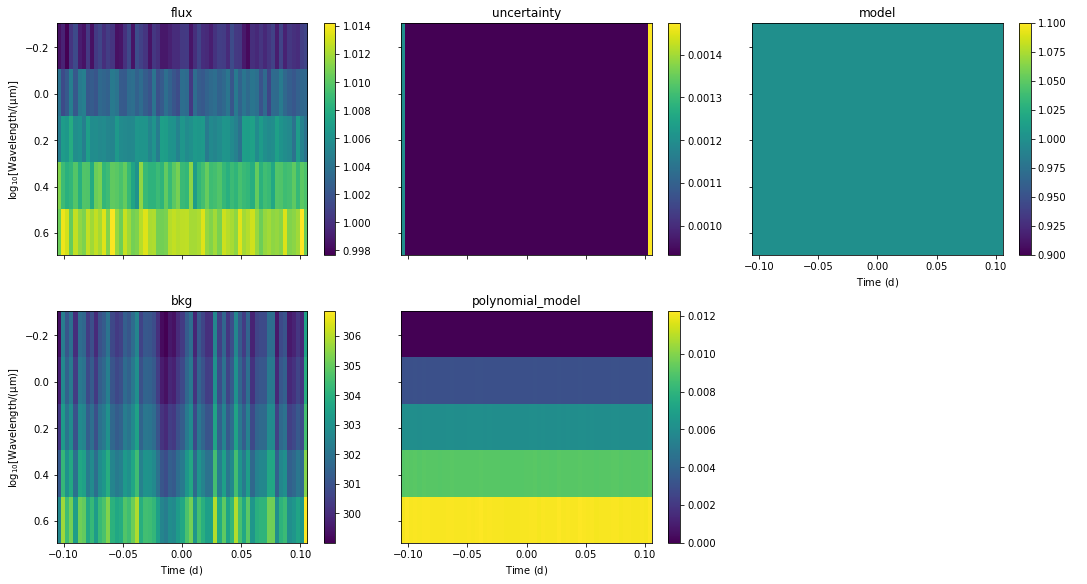

In [5]:
rbin5.imshow_quantities();

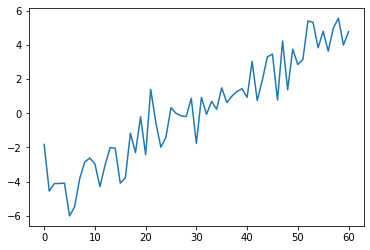

In [6]:
plt.plot(rbin5.x)

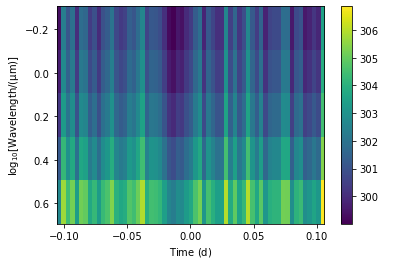

In [7]:
rbin5.imshow(quantity='bkg');

### Setup Polynomial model

In [8]:
# set up polynomial model:
b = PolynomialModel(degree=1, indep_var='bkg')
# r.get, x,y,sigma = r.get_ok_data_for_wavelength
b.initialize_empty_model()
b.setup_parameters(
#     p=WavelikeFitted(Uniform,testval=0,upper=0.1,lower=-0.1)
    p_0 = 1.0,
    p_1 = WavelikeFitted(Uniform,testval=0,upper=0.5,lower=-0.5),
#     p_2=Fixed(-0.01)
)

In [9]:
b.parameters

{'p_0': <🧮 Fixed | 1.0 🧮>,
 'p_1': <🧮 WavelikeFitted Uniform(testval=0, upper=0.5, lower=-0.5, name='p_1') for each wavelength 🧮>}

In [10]:
b.attach_data(rbin5)
# b.choose_optimization_method("separate")
b.setup_lightcurves()
b.setup_likelihood()

In [11]:
b.pymc3_model

In [17]:
opt = b.optimize()
b.sample(start=opt, tune=2000)
b.summarize(round_to=7, fmt='wide')

optimizing logp for variables: [p_1_w4, p_1_w3, p_1_w2, p_1_w1, p_1_w0]


message: Desired error not necessarily achieved due to precision loss.
logp: -7710.798058962829 -> 1684.4413332979468



🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_1_w4, p_1_w3, p_1_w2, p_1_w1, p_1_w0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.


                mean            sd    hdi_3%       hdi_97%  mcse_mean  \
p_1_w0 -5.000000e-07  4.000000e-07 -0.000001  2.000000e-07        0.0   
p_1_w1  1.010000e-05  4.000000e-07  0.000009  1.080000e-05        0.0   
p_1_w2  1.950000e-05  4.000000e-07  0.000019  2.030000e-05        0.0   
p_1_w3  3.020000e-05  4.000000e-07  0.000029  3.100000e-05        0.0   
p_1_w4  3.950000e-05  4.000000e-07  0.000039  4.030000e-05        0.0   

        mcse_sd     ess_bulk     ess_tail     r_hat  
p_1_w0      0.0  4405.508136  2719.140605  1.000226  
p_1_w1      0.0  5221.528987  3363.354504  1.000668  
p_1_w2      0.0  4792.630356  3211.754100  1.000972  
p_1_w3      0.0  5050.484940  2939.273959  1.000438  
p_1_w4      0.0  4968.017114  3482.318752  0.999595  


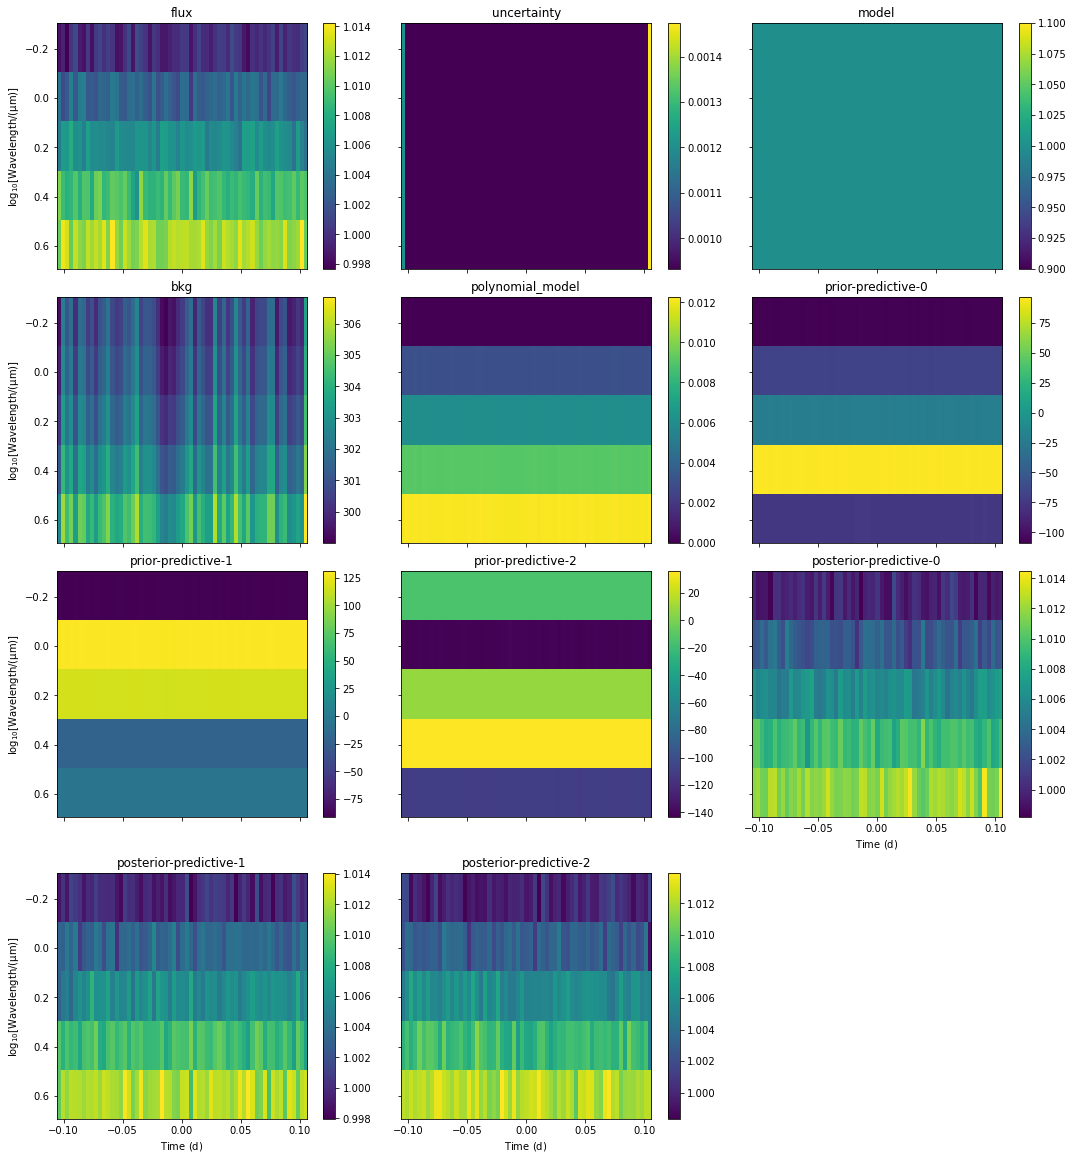

In [18]:
b.plot_priors()


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

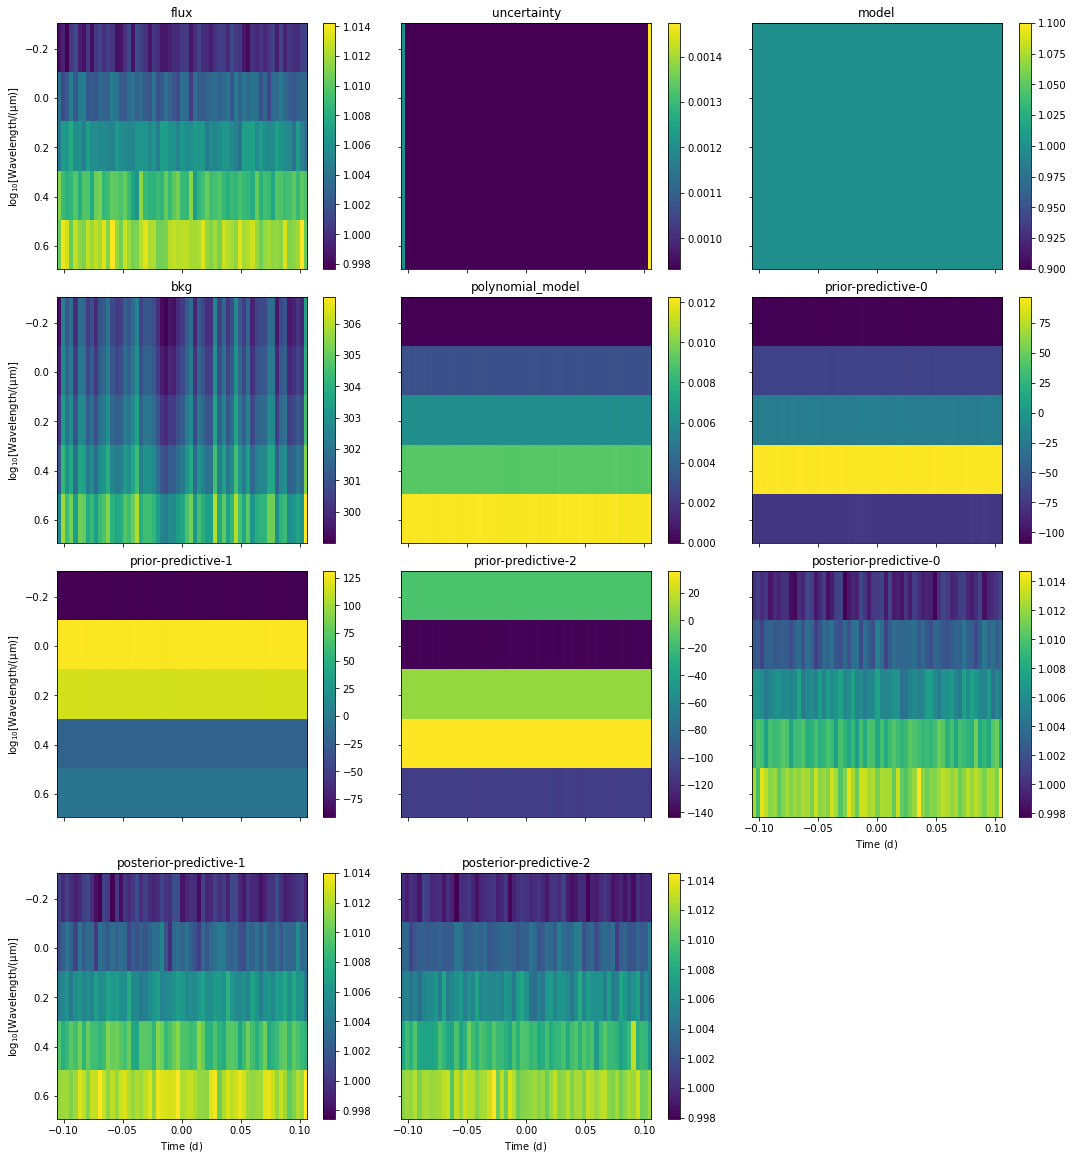

In [19]:
b.plot_posteriors()

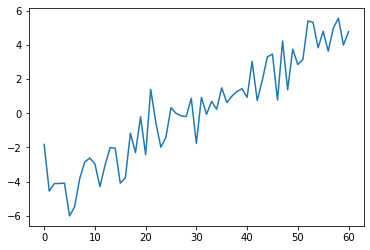

In [15]:
plt.plot(b.data.x)

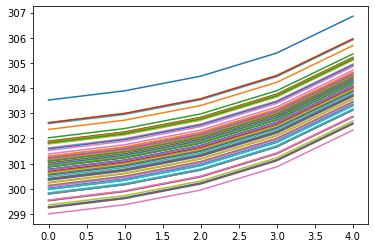

In [20]:
plt.plot(b.data.bkg);

### Combined Transit + Polynomial Model:

In [4]:
t3 = TransitModel()
t3.initialize_empty_model()

t3.setup_parameters(
#      period=Fitted(Uniform,testval=4.055259,lower=0.000009),
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.5, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = Fitted(Uniform, lower=0.95,upper=1.05)
                )

In [67]:
## combine the models!
cm = CombinedModel()
cm.initialize_empty_model()
cm.attach_models({'transit':t3,'polynomial':b})
cm.attach_data(r)
cm.setup_lightcurves()
cm.setup_likelihood()
print(cm.chromatic_models)
print(cm.pymc3_model)

100%|█████████████████████████████████████████| 5/5 [00:00<00:00, 108660.73it/s]


{'transit': <experimental chromatic transit model 🌈>, 'polynomial': <experimental chromatic polynomial model 🌈>}
             epoch_interval__ ~ TransformedDistribution
    impact_parameter_impact__ ~ TransformedDistribution
    stellar_radius_interval__ ~ TransformedDistribution
      stellar_mass_interval__ ~ TransformedDistribution
limb_darkening_quadlimbdark__ ~ TransformedDistribution
              radius_ratio_w0 ~ Normal
          baseline_interval__ ~ TransformedDistribution
              radius_ratio_w1 ~ Normal
              radius_ratio_w2 ~ Normal
              radius_ratio_w3 ~ Normal
              radius_ratio_w4 ~ Normal
              p_w0_interval__ ~ TransformedDistribution
              p_w1_interval__ ~ TransformedDistribution
              p_w2_interval__ ~ TransformedDistribution
              p_w3_interval__ ~ TransformedDistribution
              p_w4_interval__ ~ TransformedDistribution
                        epoch ~ Uniform
             impact_parameter ~ Impa


🌈 Warning: invalid value encountered in log

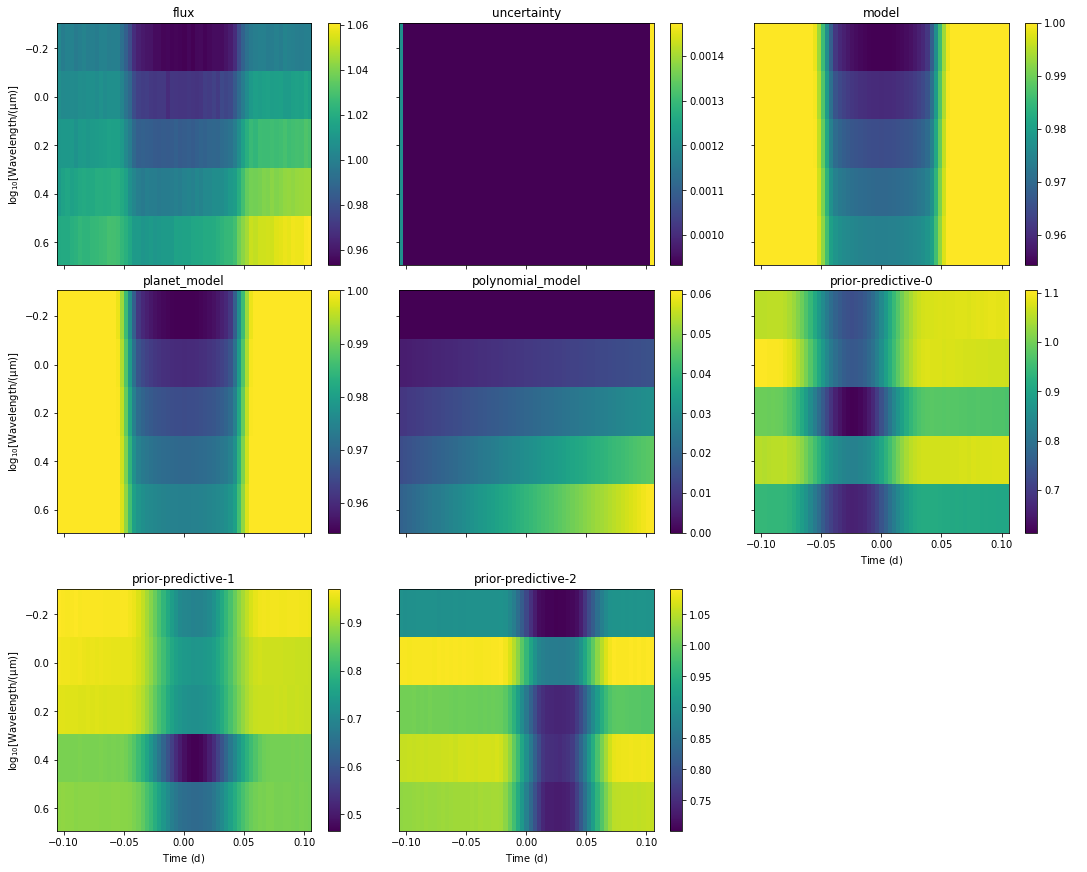

In [68]:
cm.plot_priors()

In [ ]:
cm.sample(tune=3000, draws=3000, cores=12, chains=4)
cm.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 12 jobs)
NUTS: [p_w4, p_w3, p_w2, p_w1, p_w0, radius_ratio_w4, radius_ratio_w3, radius_ratio_w2, radius_ratio_w1, baseline, radius_ratio_w0, limb_darkening, stellar_mass, stellar_radius, impact_parameter, epoch]



🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

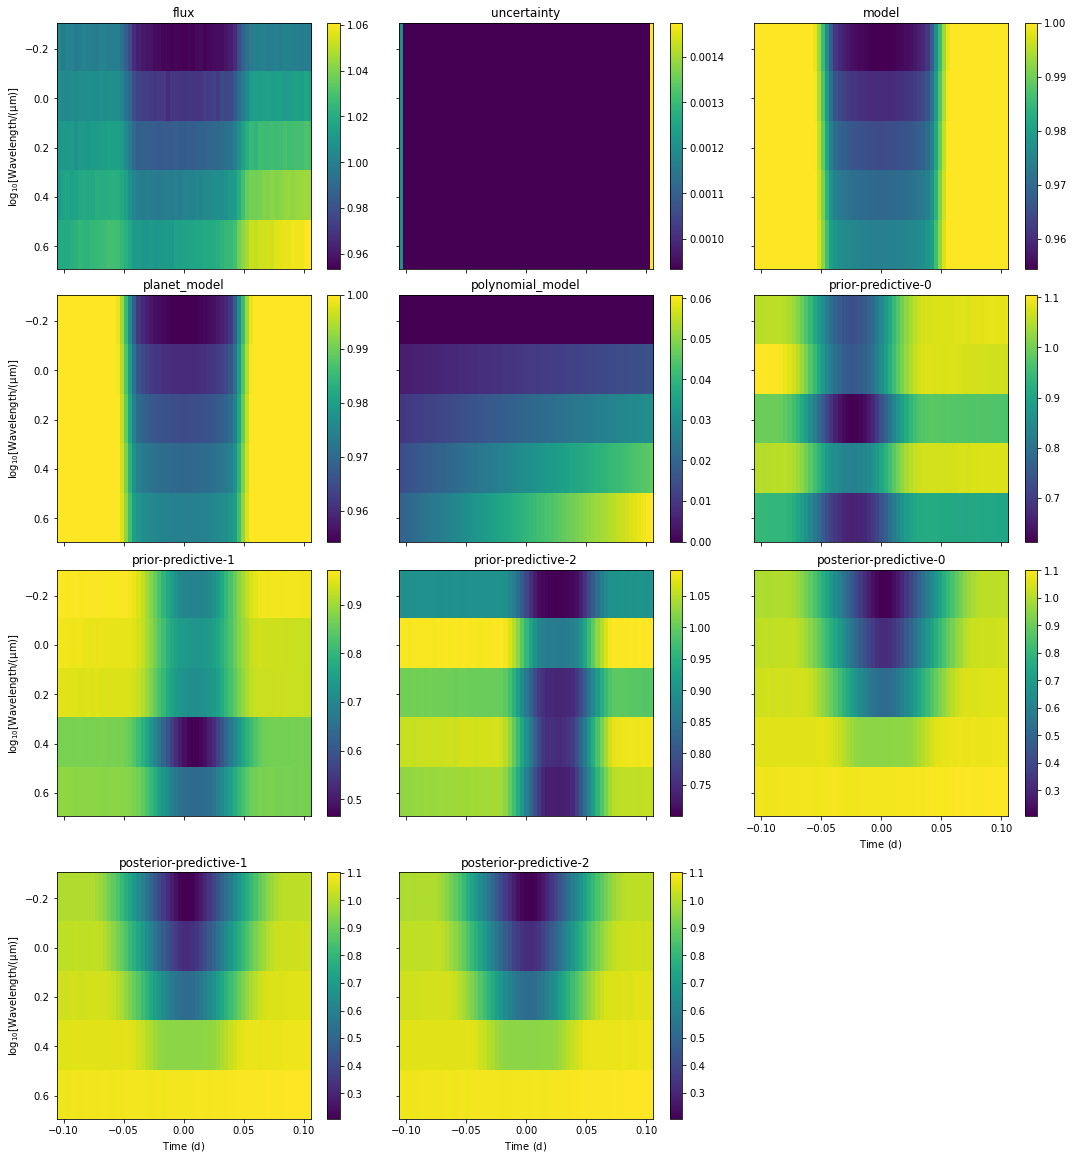

In [70]:
cm.plot_posteriors()